# Imports

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.lines as line
import pygeos as pg

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Data

Considering [Boulder's Low-Stress Walk and Bike Network Plan,](https://bouldercolorado.gov/projects/low-stress-walk-and-bike-network-plan) by [this paper:](https://bouldercolorado.gov/media/4530/download?inline=)

On page 34, the paper indicates that roads are chosen based on the following criteria:
* Equity index; areas with a lower equity index are valued more. Here is [Denver's equity index data.](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-equity-index-2020-neighborhood)
* Population and employment density; higher density neighborhoods are valued more.
  * Population and employment density are considered as part of the [Pedestrian Demand Index.](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-pedestrian-demand-index)
* Density of crashes; more heavily weighted for pedestrian or bicyclist-involved crashes. Here is [Denver's crash data.](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-traffic-accidents)
* Key destinations; the paper specifies parks, schools, and high-frequency transit stops, though it also indicates libraries, fitness centers, trailheads, restaurants, cafes, and grocery stores.
  * [Here](https://www.denvergov.org/opendata/dataset/city-and-county-of-denver-parks) is park data, [here](https://mygeodata.cloud/data/download/osm/schools/united-states-of-america--colorado/denver-county/denver) is school data, and [here](https://gis-rtd-denver.opendata.arcgis.com/maps/e14366d810644a3c95a4f3770799bd54/about) is RTD transit stop data.

#Neigborhood Selection

##Equity Data

Storing equity data.

In [4]:
equity_data = gpd.read_file("equity_index_2020___neighborhood.gdb", driver="OpenFileGDB")
equity_data

,NBRHD_NAME,SOCIOECON_SCORE,ACCESSTOCARE_SCORE,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,SHAPE_Length,SHAPE_Area,geometry
0,University Hills,4.0,4.5,2.5,3.0,3.5,3.5,0.115736,0.000395,"MULTIPOLYGON (((-104.93398 39.67845, -104.9339..."
1,Harvey Park,2.0,2.5,2.0,3.0,1.5,2.2,0.105342,0.000458,"MULTIPOLYGON (((-105.02511 39.66772, -105.0260..."
2,Mar Lee,2.0,1.5,2.5,2.0,3.5,2.3,0.085462,0.000410,"MULTIPOLYGON (((-105.02506 39.69675, -105.0250..."
3,East Colfax,1.5,1.5,3.5,1.0,2.0,1.9,0.073874,0.000291,"MULTIPOLYGON (((-104.88466 39.74746, -104.8846..."
4,Capitol Hill,4.0,2.5,4.0,1.0,4.0,3.1,0.054472,0.000184,"MULTIPOLYGON (((-104.97341 39.74003, -104.9729..."
...,...,...,...,...,...,...,...,...,...,...
73,Whittier,3.0,2.5,4.0,2.0,3.0,2.9,0.049779,0.000153,"MULTIPOLYGON (((-104.95977 39.75072, -104.9603..."
74,Cole,1.5,2.5,3.5,1.0,4.0,2.5,0.046895,0.000139,"MULTIPOLYGON (((-104.95975 39.76199, -104.9603..."
75,Westwood,1.0,1.5,3.0,2.0,2.5,2.0,0.085487,0.000407,"MULTIPOLYGON (((-105.03970 39.71125, -105.0384..."
76,Sunnyside,2.0,3.0,2.5,2.0,2.5,2.4,0.082679,0.000388,"MULTIPOLYGON (((-104.99818 39.78256, -104.9982..."


Plotting neighborhoods by overall equity score.

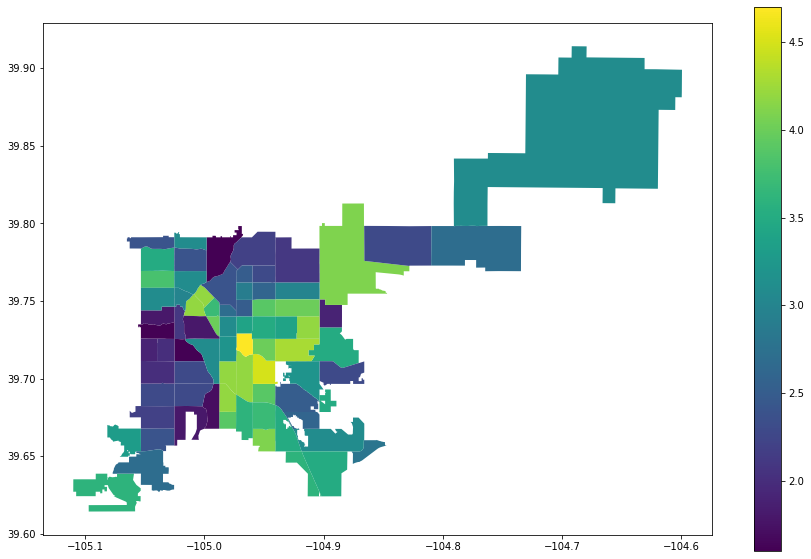

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
equity_data.plot(column="OVERALLEQUITY_SCORE", ax=ax, legend=True)

##Pedestrian Demand Data

Storing pedestrian demand data.

In [6]:
pedestrian_data = gpd.read_file("pedestrian_demand_index.gdb", driver="OpenFileGDB")
pedestrian_data

,GEOID10,PDI_Score,PDI_Ranking,SHAPE_Length,SHAPE_Area,geometry
0,0803100412146,10,HIGH,0.005259,0.000002,"MULTIPOLYGON (((-104.99272 39.74744, -104.9929..."
1,0803100409310,8,HIGH,0.033493,0.000064,"MULTIPOLYGON (((-104.95938 39.66789, -104.9593..."
2,0803100410310,1,LOW,0.031635,0.000046,"MULTIPOLYGON (((-104.85573 39.66044, -104.8556..."
3,0803100407030,8,HIGH,0.040299,0.000073,"MULTIPOLYGON (((-104.89524 39.73595, -104.8952..."
4,0803100410130,8,HIGH,0.039525,0.000073,"MULTIPOLYGON (((-104.91274 39.67846, -104.9127..."
...,...,...,...,...,...,...
474,0803100409140,5,MEDIUM,0.027482,0.000042,"MULTIPOLYGON (((-104.98277 39.69662, -104.9827..."
475,0803100407280,9,HIGH,0.044002,0.000084,"MULTIPOLYGON (((-104.87828 39.70008, -104.8781..."
476,0803100408310,7,HIGH,0.046236,0.000075,"MULTIPOLYGON (((-105.03462 39.65328, -105.0346..."
477,0803100405060,7,HIGH,0.046366,0.000057,"MULTIPOLYGON (((-105.00634 39.73690, -105.0063..."


Plotting neighborhoods by pedestrian demand index score.

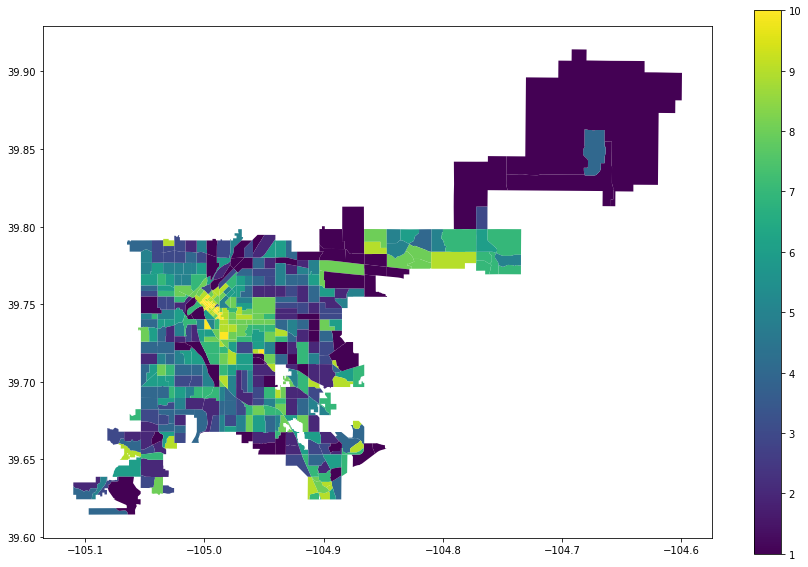

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
pedestrian_data.plot(column="PDI_Score", ax=ax, legend=True)

##Merging Equity and Pedestrian Demand

Adding column "EQUITY_SCORE_10" scaling overall equity score so that its max value is 10.

In [8]:
equity_score_10 = equity_data["OVERALLEQUITY_SCORE"]
equity_score_10 = (equity_score_10 / max(equity_score_10)) * 10
equity_data.insert(7, "EQUITY_SCORE_10", equity_score_10, False)

Merging equity data and pedestrian data. This merge uses predicate "intersects," so some pedestrian data entries may be counted multiple times if they intersect with multiple equity data entries.

In [9]:
equity_ped_data = equity_data.sjoin(pedestrian_data)
equity_ped_data

,NBRHD_NAME,SOCIOECON_SCORE,ACCESSTOCARE_SCORE,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,SHAPE_Length_left,SHAPE_Area_left,geometry,index_right,GEOID10,PDI_Score,PDI_Ranking,SHAPE_Length_right,SHAPE_Area_right
0,University Hills,4.0,4.5,2.5,3.0,3.5,3.5,7.446809,0.115736,0.000395,"MULTIPOLYGON (((-104.93398 39.67845, -104.9339...",139,0803100411020,3,LOW,0.061060,0.000150
62,Southmoor Park,4.0,4.5,3.0,5.0,1.5,3.6,7.659575,0.107831,0.000253,"MULTIPOLYGON (((-104.90186 39.62409, -104.9040...",139,0803100411020,3,LOW,0.061060,0.000150
63,Hampden South,4.5,4.0,2.5,4.0,2.5,3.5,7.446809,0.120254,0.000791,"MULTIPOLYGON (((-104.90205 39.62443, -104.9023...",139,0803100411020,3,LOW,0.061060,0.000150
0,University Hills,4.0,4.5,2.5,3.0,3.5,3.5,7.446809,0.115736,0.000395,"MULTIPOLYGON (((-104.93398 39.67845, -104.9339...",309,0803100411030,7,HIGH,0.053230,0.000083
61,Hampden,3.0,3.0,3.0,4.0,2.5,3.1,6.595745,0.200578,0.000768,"MULTIPOLYGON (((-104.86602 39.66027, -104.8663...",309,0803100411030,7,HIGH,0.053230,0.000083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Whittier,3.0,2.5,4.0,2.0,3.0,2.9,6.170213,0.049779,0.000153,"MULTIPOLYGON (((-104.95977 39.75072, -104.9603...",380,0803100402251,5,MEDIUM,0.024724,0.000038
74,Cole,1.5,2.5,3.5,1.0,4.0,2.5,5.319149,0.046895,0.000139,"MULTIPOLYGON (((-104.95975 39.76199, -104.9603...",380,0803100402251,5,MEDIUM,0.024724,0.000038
77,DIA,3.5,3.0,3.0,5.0,1.0,3.1,6.595745,0.632723,0.011551,"MULTIPOLYGON (((-104.76269 39.79833, -104.7629...",197,0803100413050,1,LOW,0.260341,0.001149
77,DIA,3.5,3.0,3.0,5.0,1.0,3.1,6.595745,0.632723,0.011551,"MULTIPOLYGON (((-104.76269 39.79833, -104.7629...",291,0803100413060,4,LOW,0.096484,0.000456


* Since "pedestrian_data" is spatially subdivided more than "equity_data", the following code finds the average "PDI_Score" for each neighborhood in "equity_data," storing those values in "AVG_PDI_SCORE." 
* It then scales those averages so their max value is 10, storing those values in "AVG_PDI_10." 
* Finally it takes the difference of "AVG_PDI_10" and "EQUITY_SCORE_10" for each neighborhood, and stores those values in "PDI_EQUITY_DIFF." I.e., higher PDI scores and lower equity scores are more desirable, lower PDI scores and higher equity scores are less desirable. 
* Additionally, since PDI and Equity are both scaled to have max values of 10, they are weighed equally in consideration.

In [10]:
nbrhd_count = [0] * len(equity_data)
nbrhd_total = [0] * len(equity_data)

#kind of inefficient, but finding average PDI score for smaller neighborhoods
#in each larger neighborhood
for i in range(len(equity_ped_data)):
  for j in range(len(equity_data)):
    if (equity_ped_data.iat[i,0] == equity_data.iat[j,0]):
      nbrhd_count[j] += 1
      nbrhd_total[j] += equity_ped_data.iat[i,13]

In [11]:
AVG_PDI_SCORE = [0] * len(equity_data)

#storing average PDI score for each neighborhood in equity_data
for i in range(len(equity_data)):
  AVG_PDI_SCORE[i] = nbrhd_total[i] / nbrhd_count[i]

#scaling AVG_PDI_SCORe by 10
AVG_PDI_10 = (AVG_PDI_SCORE / max(AVG_PDI_SCORE)) * 10

#finding difference between pedestrian demand and equity
PDI_EQUITY_DIFF = AVG_PDI_10 - equity_score_10

#adding all three new variables to equity_data
equity_data.insert(8, "AVG_PDI_SCORE", AVG_PDI_SCORE, False)
equity_data.insert(9, "AVG_PDI_10", AVG_PDI_10, False)
equity_data.insert(10, "PDI_EQUITY_DIFF", PDI_EQUITY_DIFF, False)

equity_data

,NBRHD_NAME,SOCIOECON_SCORE,ACCESSTOCARE_SCORE,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length,SHAPE_Area,geometry
0,University Hills,4.0,4.5,2.5,3.0,3.5,3.5,7.446809,4.428571,4.942169,-2.504639,0.115736,0.000395,"MULTIPOLYGON (((-104.93398 39.67845, -104.9339..."
1,Harvey Park,2.0,2.5,2.0,3.0,1.5,2.2,4.680851,3.500000,3.905908,-0.774943,0.105342,0.000458,"MULTIPOLYGON (((-105.02511 39.66772, -105.0260..."
2,Mar Lee,2.0,1.5,2.5,2.0,3.5,2.3,4.893617,4.933333,5.505470,0.611853,0.085462,0.000410,"MULTIPOLYGON (((-105.02506 39.69675, -105.0250..."
3,East Colfax,1.5,1.5,3.5,1.0,2.0,1.9,4.042553,3.083333,3.440919,-0.601634,0.073874,0.000291,"MULTIPOLYGON (((-104.88466 39.74746, -104.8846..."
4,Capitol Hill,4.0,2.5,4.0,1.0,4.0,3.1,6.595745,8.736842,9.750086,3.154342,0.054472,0.000184,"MULTIPOLYGON (((-104.97341 39.74003, -104.9729..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Whittier,3.0,2.5,4.0,2.0,3.0,2.9,6.170213,5.454545,6.087130,-0.083084,0.049779,0.000153,"MULTIPOLYGON (((-104.95977 39.75072, -104.9603..."
74,Cole,1.5,2.5,3.5,1.0,4.0,2.5,5.319149,4.333333,4.835886,-0.483263,0.046895,0.000139,"MULTIPOLYGON (((-104.95975 39.76199, -104.9603..."
75,Westwood,1.0,1.5,3.0,2.0,2.5,2.0,4.255319,5.117647,5.711160,1.455840,0.085487,0.000407,"MULTIPOLYGON (((-105.03970 39.71125, -105.0384..."
76,Sunnyside,2.0,3.0,2.5,2.0,2.5,2.4,5.106383,4.222222,4.711889,-0.394494,0.082679,0.000388,"MULTIPOLYGON (((-104.99818 39.78256, -104.9982..."


Testing to see if there's any correlation between equity and pedestrian demand.

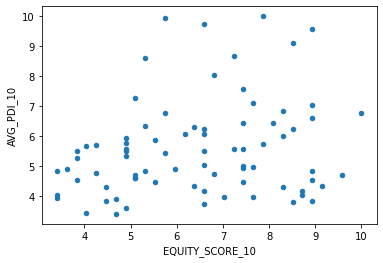

In [12]:
equity_data.plot.scatter(x = "EQUITY_SCORE_10", y = "AVG_PDI_10")

Plotting neighborhoods by "PDI_EQUITY_DIFF."

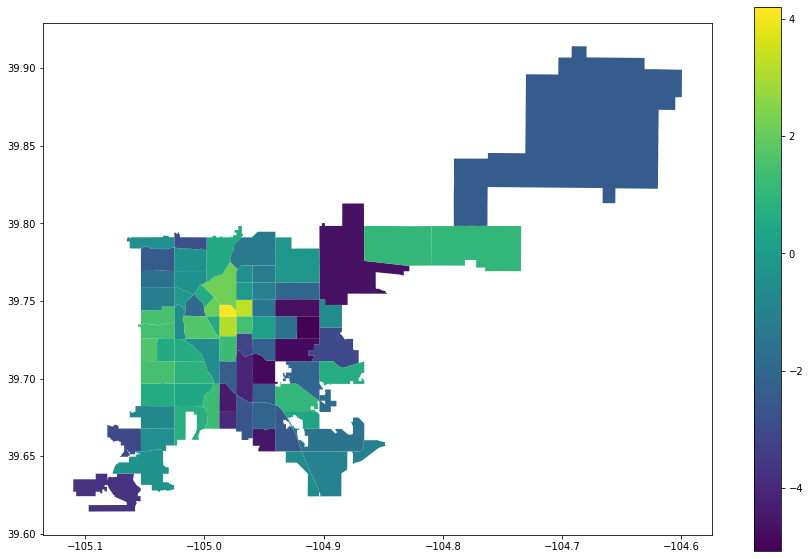

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
equity_data.plot(column="PDI_EQUITY_DIFF", ax=ax, legend=True)

Finding and storing top 5 neighborhoods in "nbrhds_of_interest."

In [14]:
nbrhds_of_interest = equity_data.sort_values(by = ["PDI_EQUITY_DIFF"], ascending = False)[0:5]
nbrhds_of_interest

,NBRHD_NAME,SOCIOECON_SCORE,ACCESSTOCARE_SCORE,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length,SHAPE_Area,geometry
5,North Capitol Hill,3.0,2.0,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096,"MULTIPOLYGON (((-104.97338 39.74378, -104.9733..."
15,City Park West,2.5,3.0,2.0,1.0,4.0,2.5,5.319149,7.714286,8.608940,3.289791,0.048647,0.000146,"MULTIPOLYGON (((-104.95978 39.73999, -104.9604..."
4,Capitol Hill,4.0,2.5,4.0,1.0,4.0,3.1,6.595745,8.736842,9.750086,3.154342,0.054472,0.000184,"MULTIPOLYGON (((-104.97341 39.74003, -104.9729..."
19,Five Points,2.5,1.5,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479,"MULTIPOLYGON (((-104.97192 39.77030, -104.9733..."
7,CBD,2.5,2.0,4.0,5.0,5.0,3.7,7.872341,8.960784,10.000000,2.127659,0.042534,0.000117,"MULTIPOLYGON (((-104.98740 39.74736, -104.9874..."


Plotting neighborhoods of interest.

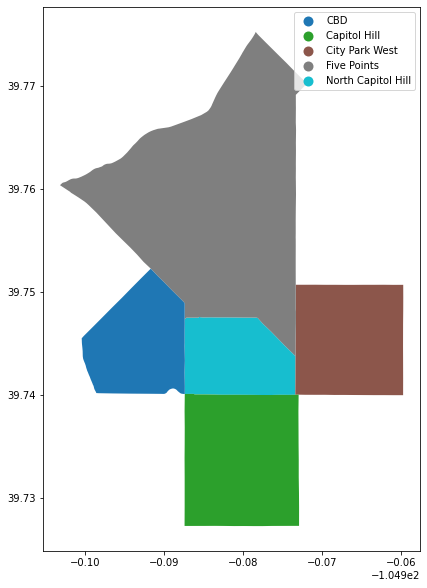

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, legend=True)

#Street Selection

##Crash Data

Storing crash data.

In [16]:
crash_data = gpd.read_file("traffic_accidents.gdb", driver="OpenFileGDB")
crash_data

,OBJECTID_1,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,TOP_TRAFFIC_ACCIDENT_OFFENSE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,...,TU2_DRIVER_ACTION,TU2_DRIVER_HUMANCONTRIBFACTOR,TU2_PEDESTRIAN_ACTION,SERIOUSLY_INJURED,FATALITIES,FATALITY_MODE_1,FATALITY_MODE_2,SERIOUSLY_INJURED_MODE_1,SERIOUSLY_INJURED_MODE_2,geometry
0,1.0,2017100002,201710000254410,5441,0,TRAF - ACCIDENT,I70 HWYEB / N NORTHFIELD QUEBEC ST,3167637.0,1708927.0,-104.903568,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-104.90357 39.77830)
1,2.0,2017100074,201710007454410,5441,0,TRAF - ACCIDENT,3200 N BRIGHTON BLVD,3145663.0,1704934.0,-104.981828,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-104.98183 39.76771)
2,3.0,2017100083,201710008354410,5441,0,TRAF - ACCIDENT,I70 HWYEB / I270 HWYWB,3174254.0,1708511.0,-104.880037,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-104.88004 39.77704)
3,4.0,2017100084,201710008454410,5441,0,TRAF - ACCIDENT,W 1ST AVENUE / N VRAIN STREET,NaN,NaN,NaN,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,None
4,5.0,2017100117,201710011754010,5401,0,TRAF - ACCIDENT - HIT & RUN,S PLATTE RIVER DR / W TENNESSEE AVE,3142747.0,1679702.0,-104.992702,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-104.99270 39.69849)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110465,110466.0,20229842,2022984254410,5441,0,TRAF - ACCIDENT,19TH ST / STOUT ST,3143560.0,1697979.0,-104.989448,...,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,NaN,NaN,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,POINT (-104.98945 39.74865)
110466,110467.0,20229868,2022986854410,5441,0,TRAF - ACCIDENT,4600 BLOCK MORRISON RD,3127352.0,1680475.0,-105.047399,...,0,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-105.04740 39.70083)
110467,110468.0,20229871,2022987154010,5401,0,TRAF - ACCIDENT - HIT & RUN,1500 BLOCK S IRVING ST,3132377.0,1676030.0,-105.029622,...,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,NaN,NaN,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,POINT (-105.02962 39.68856)
110468,110469.0,20229912,2022991254410,5441,0,TRAF - ACCIDENT,1200 BLOCK S FEDERAL BLVD,3133726.0,1678329.0,-105.024786,...,OTHER,OTHER,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-105.02479 39.69485)


Subsetting crash data by pedestrian-involved, bicyclist-involved, or involving serious injury or death.

In [17]:
crash_data = crash_data[(crash_data["BICYCLE_IND"] > 0) | (crash_data["PEDESTRIAN_IND"] > 0) | (crash_data["SERIOUSLY_INJURED"] > 0) | (crash_data["FATALITIES"] > 0)]
crash_data

,OBJECTID_1,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,TOP_TRAFFIC_ACCIDENT_OFFENSE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,...,TU2_DRIVER_ACTION,TU2_DRIVER_HUMANCONTRIBFACTOR,TU2_PEDESTRIAN_ACTION,SERIOUSLY_INJURED,FATALITIES,FATALITY_MODE_1,FATALITY_MODE_2,SERIOUSLY_INJURED_MODE_1,SERIOUSLY_INJURED_MODE_2,geometry
44,45.0,2017101418,201710141854411,5441,1,TRAF - ACCIDENT - SBI,2600 BLOCK S MONACO ST,3165327.0,1669042.0,-104.912704,...,OTHER,OTHER,OTHER,1.0,0.0,OTHER,OTHER,PEDESTRIAN,OTHER,POINT (-104.91270 39.66885)
51,52.0,2017102174,201710217454410,5441,0,TRAF - ACCIDENT,3550 S KENDALL ST,3122263.0,1662642.0,-105.065788,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-105.06579 39.65195)
67,68.0,2017102725,201710272554410,5441,0,TRAF - ACCIDENT,I70 HWYWB / N BRIGHTON BLVD,3149779.0,1709487.0,-104.967092,...,00,NO APPARENT,OTHER,1.0,0.0,OTHER,OTHER,PASSENGER CAR/VAN,OTHER,POINT (-104.96709 39.78014)
75,76.0,2017102901,201710290154411,5441,1,TRAF - ACCIDENT - SBI,4300 BLOCK W FLORIDA AVE,3128406.0,1676323.0,-105.043727,...,OTHER,OTHER,CROSS/ENTER AT INTERSECTION,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-105.04373 39.68942)
82,83.0,2017103278,201710327854010,5401,0,TRAF - ACCIDENT - HIT & RUN,1600 BLOCK 17TH ST,3140799.0,1699264.0,-104.999242,...,00,NO APPARENT,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-104.99924 39.75222)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,110144.0,2021982,202198254411,5441,1,TRAF - ACCIDENT - SBI,W HAMPDEN AVE / S SHERIDAN BLVD,3125801.0,1663169.0,-105.053213,...,OTHER,OTHER,OTHER,1.0,0.0,OTHER,OTHER,SUV,OTHER,POINT (-105.05321 39.65335)
110154,110155.0,202198468,20219846854200,5420,0,TRAF - ACCIDENT - DUI/DUID,LEETSDALE DR / S MONACO ST,3165209.0,1681444.0,-104.912839,...,00,NO APPARENT,OTHER,2.0,0.0,OTHER,OTHER,SUV,SUV,POINT (-104.91284 39.70290)
110165,110166.0,202198624,20219862454411,5441,1,TRAF - ACCIDENT - SBI,E 11TH AVE / N ST PAUL ST,3154519.0,1692552.0,-104.950592,...,OTHER,OTHER,OTHER,1.0,0.0,OTHER,OTHER,PEDESTRIAN,OTHER,POINT (-104.95059 39.73358)
110191,110192.0,202199576,20219957654411,5441,1,TRAF - ACCIDENT - SBI,N TITAN CT / E ANDREWS DR,3185945.0,1711705.0,-104.838361,...,OTHER,OTHER,CROSS/ENTER AT INTERSECTION,0.0,0.0,OTHER,OTHER,OTHER,OTHER,POINT (-104.83836 39.78558)


Subsetting "crash_data" by intersecting with "nbrhds_of_interest."

In [18]:
crash_data = crash_data.sjoin(nbrhds_of_interest)
crash_data

,OBJECTID_1,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,TOP_TRAFFIC_ACCIDENT_OFFENSE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,...,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length,SHAPE_Area
756,757.0,2017129310,201712931054411,5441,1,TRAF - ACCIDENT - SBI,E 14TH AVE / N WASHINGTON ST,3146596.0,1694270.0,-104.978727,...,4.0,1.0,4.0,3.1,6.595745,8.736842,9.750086,3.154342,0.054472,0.000184
1401,1402.0,2017154488,201715448854411,5441,1,TRAF - ACCIDENT - SBI,700 BLOCK N SHERMAN ST,3144911.0,1690528.0,-104.984794,...,4.0,1.0,4.0,3.1,6.595745,8.736842,9.750086,3.154342,0.054472,0.000184
1607,1608.0,2017161884,201716188454410,5441,0,TRAF - ACCIDENT,E 14TH AVE / N CORONA ST,3147888.0,1694278.0,-104.974133,...,4.0,1.0,4.0,3.1,6.595745,8.736842,9.750086,3.154342,0.054472,0.000184
1805,1806.0,2017169902,201716990254411,5441,1,TRAF - ACCIDENT - SBI,E 10TH AVE / N LINCOLN ST,3144528.0,1691934.0,-104.986127,...,4.0,1.0,4.0,3.1,6.595745,8.736842,9.750086,3.154342,0.054472,0.000184
2305,2306.0,2017185042,201718504254410,5441,0,TRAF - ACCIDENT,1200 BLOCK N WASHINGTON ST,3146630.0,1693395.0,-104.978624,...,4.0,1.0,4.0,3.1,6.595745,8.736842,9.750086,3.154342,0.054472,0.000184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84950,84951.0,202055522,20205552254410,5441,0,TRAF - ACCIDENT,N MARION ST / E 16TH AVE,3148437.0,1695453.0,-104.972156,...,2.0,1.0,4.0,2.5,5.319149,7.714286,8.608940,3.289791,0.048647,0.000146
86212,86213.0,2020601028,202060102854410,5441,0,TRAF - ACCIDENT,N GILPIN ST / E 16TH AVE,3149825.0,1695456.0,-104.967221,...,2.0,1.0,4.0,2.5,5.319149,7.714286,8.608940,3.289791,0.048647,0.000146
95302,95303.0,202124052,20212405254010,5401,0,TRAF - ACCIDENT - HIT & RUN,1500 BLOCK N FRANKLIN ST,3149504.0,1695065.0,-104.968370,...,2.0,1.0,4.0,2.5,5.319149,7.714286,8.608940,3.289791,0.048647,0.000146
95448,95449.0,2021246109,202124610954410,5441,0,TRAF - ACCIDENT,1715 N WILLIAMS ST,3150143.0,1696166.0,-104.966075,...,2.0,1.0,4.0,2.5,5.319149,7.714286,8.608940,3.289791,0.048647,0.000146


Plotting crashes within neighborhoods of interest.

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


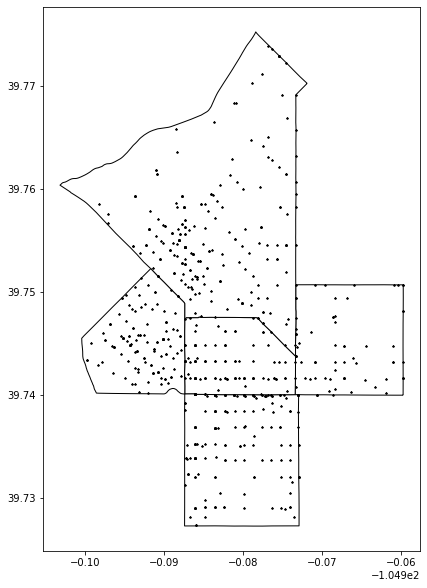

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, color = "white", edgecolor = "black")
crash_data.plot(ax = base, marker = "*", color = "black", markersize = 3)

##Key Destinations

###Park Data

Storing park data.

In [20]:
park_data = gpd.read_file("parks.gdb", driver="OpenFileGDB")
park_data

,LOCATION,FORMAL_NAME,LOC_CODE,PARK_TYPE,PARK_CLASS,GIS_ACRES,DESIGNATED,FIRST_AQ_DATE,MASTER_PLAN,MAINT_DIST,...,LONGITUDE,MARKETING_CODE,FACILITIES,DIAGRAM,PHOTO,PARCEL_MATCH,BND_QC,SHAPE_Length,SHAPE_Area,geometry
0,Verbena,Verbena Park,L18,Park,Neighborhood,7.185635,Yes,1969,None,NE,...,-104.891271,PK,"Picnic Shelter, Picnic Tables, Benches, Playgr...",ParkArt_Verbena Park.pdf,verbenapark.jpg,Yes,2015-09-09T00:00:00+00:00,0.007571,3.055237e-06,"MULTIPOLYGON (((-104.89070 39.73294, -104.8918..."
1,Legault Mountain,Legault Mountain Tracts,M30,Conservation Tract,Mountain,134.790235,Yes,1924,2008,MP,...,-105.245073,None,"Scenic View Shed, Natural Open Space",,no_imagerec.gif,None,2010-05-14T00:00:00+00:00,0.053131,5.714989e-05,"MULTIPOLYGON (((-105.24317 39.53059, -105.2431..."
2,Hobbs Peak,Hobbs Peak Tract,M29,Conservation Tract,Mountain,38.849537,Yes,1925,2008,MP,...,-105.302888,None,"Scenic View Shed, Natural Open Space",,no_imagerec.gif,None,2010-05-21T00:00:00+00:00,0.016372,1.648583e-05,"MULTIPOLYGON (((-105.30059 39.59120, -105.3012..."
3,City of Takayama,City of Takayama Park,331,Park,Linear,6.060320,Yes,1966,None,E,...,-104.943746,PK,"Benches, Bike/Pedestrian Path, Cherry Creek Trail",ParkArt_City of Takayama Park.pdf,takayamapark.jpg,No,2009-09-30T00:00:00+00:00,0.016074,2.575860e-06,"MULTIPOLYGON (((-104.94715 39.71108, -104.9464..."
4,Highline Canal (Parker to Havana),Highline Canal (Parker to Havana),661,Park,Linear,28.792370,Not Eligible,N/A - DW (1980s),N/A,NE,...,-104.884899,None,"Bike/Pedestrian Path, High Line Canal Trail, O...",ParkArt_Highline Canal.pdf,no_imagerec.gif,Yes,2009-06-08T00:00:00+00:00,0.085017,1.223663e-05,"MULTIPOLYGON (((-104.89017 39.70461, -104.8901..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,Platt,Platt (James H) Park,824,Park,Neighborhood,3.726433,Yes - 1956,1894,2002,SW,...,-104.983403,PK,"Recreation Center, Library, Flemming Mansion (...",ParkArt_Platt (James H) Park.pdf,plattpark.jpg,Yes,2009-06-25T00:00:00+00:00,0.005229,1.583423e-06,"MULTIPOLYGON (((-104.98388 39.68765, -104.9838..."
351,The Urban Farm,The Urban Farm,585,Park,Special Use,21.425295,Yes - 2016 November,2015,None,NE,...,-104.872662,None,The Urban Farm,None,None,No,2020-06-02T00:00:00+00:00,0.016244,9.113835e-06,"MULTIPOLYGON (((-104.86879 39.76860, -104.8687..."
352,Genesee,Genesee Park,M26,Park,Mountain,2407.008034,Yes,1926,2008,MP,...,-105.310784,MP,"Views, Bison Herd, Trails, Picnic Shelter, Pic...",Genesee_ParkMap.pdf,geneseepark.jpg,None,2010-05-20T00:00:00+00:00,0.248860,1.023158e-03,"MULTIPOLYGON (((-105.30374 39.73179, -105.3038..."
353,Village Place,Village Place Park,540,Park,Neighborhood,9.780213,Yes,1979,None,NE,...,-104.832710,PK,"Benches, Drinking Fountain, Picnic Shelter, Fl...",ParkArt_Village Place Park.pdf,villageplacepark.jpg,Yes,2008-11-25T00:00:00+00:00,0.008398,4.160941e-06,"MULTIPOLYGON (((-104.83184 39.77691, -104.8319..."


Subsetting park data by intersecting with neighborhoods of interest.

In [21]:
park_data = park_data.sjoin(nbrhds_of_interest)
park_data

,LOCATION,FORMAL_NAME,LOC_CODE,PARK_TYPE,PARK_CLASS,GIS_ACRES,DESIGNATED,FIRST_AQ_DATE,MASTER_PLAN,MAINT_DIST,...,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length_right,SHAPE_Area_right
27,MacIntosh,MacIntosh (Kenneth M) Park,236,Park,Pocket,0.325579,Yes,1982,None,Downtown,...,4.0,5.0,5.0,3.7,7.872341,8.960784,10.000000,2.127659,0.042534,0.000117
128,Skyline,Skyline Park,332,Park,Special Use,2.560731,Yes - 1994,1973,2002,Downtown,...,4.0,5.0,5.0,3.7,7.872341,8.960784,10.000000,2.127659,0.042534,0.000117
191,Sculpture,Sculpture Park,340,Park,Special Use,2.530312,Yes - 1981,1960s,None,Downtown,...,4.0,5.0,5.0,3.7,7.872341,8.960784,10.000000,2.127659,0.042534,0.000117
204,Pioneer Monument,Pioneer Monument Park,233,Park,Pocket,0.297578,Yes - 1956,1906,None,Downtown,...,4.0,5.0,5.0,3.7,7.872341,8.960784,10.000000,2.127659,0.042534,0.000117
42,Governors,Governors Park,316,Park,Neighborhood,1.976757,Yes,1966,None,E,...,4.0,1.0,4.0,3.1,6.595745,8.736842,9.750086,3.154342,0.054472,0.000184
174,Quality Hill,Quality Hill Park,342,Park,Pocket,0.281673,Yes,1979,None,E,...,4.0,1.0,4.0,3.1,6.595745,8.736842,9.750086,3.154342,0.054472,0.000184
300,Grant-Humphrey's,Grant-Humphrey's Mansion Park,338,Park,Special Use,1.884319,Yes,1977,None,E,...,4.0,1.0,4.0,3.1,6.595745,8.736842,9.750086,3.154342,0.054472,0.000184
63,20th St Rec Center,20th St Rec Center,234,Grounds,Recreation Center,0.288226,Yes,1980,None,Downtown,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
73,Benedict Fountain,Benedict Fountain Park,310,Park,Neighborhood,2.910892,Yes - 1956,1924,2009,Downtown,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
130,Mestizo-Curtis,Mestizo-Curtis Park,203,Park,Neighborhood,8.523158,Yes - 1956 / 2017 November,1868,2002,NW,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479


Plotting parks within neighborhoods of interest.

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


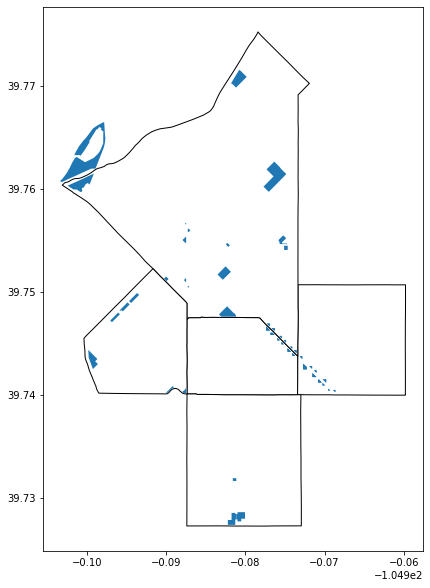

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, color = "white", edgecolor = "black")
park_data.plot(ax = base)

###School Data

Storing school data.

In [23]:
school_data = gpd.read_file("./schools/school_point.shp")
school_data

,amenity,name,ele,addr_house,addr_postc,addr_stree,addr_city,addr_state,phone,website,wikidata,old_name,alt_name,addr_unit,addr_hou_1,email,fax,operator,opening_ho,geometry
0,school,Abraham Lincoln High School,1648,None,None,None,None,None,None,None,Q4669022,None,None,None,None,None,None,None,None,POINT (-105.02693 39.67665)
1,school,Academia Ana Marie Sandoval,1617,3655,80211,Wyandot Street,Denver,CO,None,None,None,None,None,None,None,None,None,None,None,POINT (-105.01543 39.76713)
2,school,Academy of Urban Learning High School,None,2417,80211,West 29th Avenue,Denver,CO,None,None,None,None,None,None,None,None,None,None,None,POINT (-105.01689 39.75869)
3,school,Ace Community Challenge Charter School,1598,948,80204,Santa Fe Drive,Denver,CO,None,None,None,None,None,None,None,None,None,None,None,POINT (-104.99849 39.73150)
4,school,All Saints School,1649,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (-105.02637 39.67193)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,school,Wick Irish Dance,None,6460,80222,East Yale Avenue,Denver,CO,(303) 987-2427,http://wickschool.com/,None,None,Wick School of Irish Dancing,G20A1,None,None,None,None,None,POINT (-104.91543 39.66689)
173,school,Wyatt-Edison Charter School,1588,3620,80205,Franklin Street,Denver,CO,None,None,None,None,None,None,None,None,None,None,None,POINT (-104.96768 39.76763)
174,school,Yeshiva Toras Chaim,1619,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,POINT (-105.04361 39.71861)
175,school,Yeshiva Toras Chaim Talmudic Seminary of Denver,None,1555,80204,Stuart Street,Denver,CO,None,None,None,None,None,None,None,None,None,None,None,POINT (-105.04342 39.74184)


Subsetting schools data by intersecting with neighborhoods of interest.

In [24]:
school_data = school_data.sjoin(nbrhds_of_interest)
school_data

,amenity,name,ele,addr_house,addr_postc,addr_stree,addr_city,addr_state,phone,website,...,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length,SHAPE_Area
46,school,Dora Moore School,1619,846,80218,Corona Street,Denver,CO,720-424-5300,None,...,4.0,1.0,4.0,3.1,6.595745,8.736842,9.750086,3.154342,0.054472,0.000184
101,school,Morey Middle School,1613,840,80218,East 14th Avenue,Denver,CO,None,None,...,4.0,1.0,4.0,3.1,6.595745,8.736842,9.750086,3.154342,0.054472,0.000184
50,school,Emily Griffith High School,None,1860,80203,Lincoln Street,Denver,CO,None,None,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
57,school,Gilpin Montessori Public School,1592,2949,80205,California Street,Denver,CO,720-424-7140,None,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
95,school,Mile High Montessori Edna Oliver Early Learnin...,None,2851,80205,Tremont Place,Denver,CO,None,None,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
97,school,Montessori Academy of Colorado,None,2500,80205,Curtis Street,Denver,CO,None,None,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
98,school,Montessori Academy Of Colorado,None,2500,80205,Curtis Street,Denver,CO,None,None,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
117,school,Polaris At Ebert Elementary School,1598,410,80205,Park Avenue West,Denver,CO,None,None,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
127,school,Sacred Heart House of Denver,1588,2844,80205,Lawrence Street,Denver,CO,None,None,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
107,school,Oleta Crain Enrichment Academy,None,2102,80205,Marion Street,Denver,CO,None,None,...,2.0,1.0,4.0,2.5,5.319149,7.714286,8.608940,3.289791,0.048647,0.000146


Plotting schools within neighborhoods of interest.

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


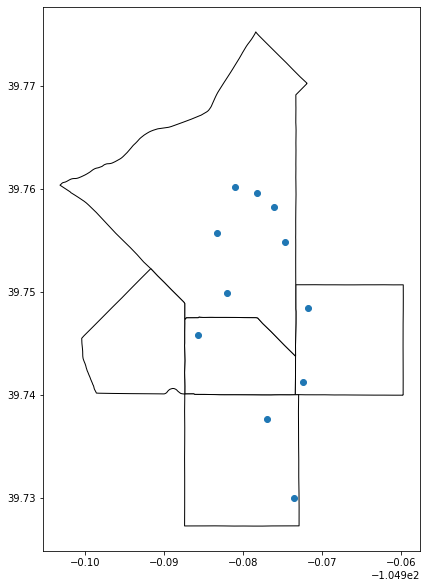

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, color = "white", edgecolor = "black")
school_data.plot(ax = base)

###Transit Stops

####Bus Stop Data

Storing bus stop data.

In [26]:
bus_data = gpd.read_file("./busstops/RTD_GIS_Current_Runboard.shp")
bus_data

,OBJECTID,BSID,LNG,LAT,X_COORD,Y_COORD,STATUS,ROUTES,STOPNAME,DIR,...,COMMENTS,ON_STREET,AT_STREET,BETWEEN__1,STATION_ID,HUBABBR,HUBNAME,SBOARDS,STOPNAME_B,geometry
0,3367927,13768,-105.025279,39.729654,3.133521e+06,1.691005e+06,active,"31, 30",Federal Blvd & W 8th Ave,S,...,AUG 2019,Federal Blvd,W 8th Av,None,NaN,None,None,0,Federal Blvd & W 8th Ave (Stop No. 13768),POINT (-105.02529 39.72966)
1,3367928,23955,-104.994238,39.759506,3.142191e+06,1.701926e+06,active,"120X, 38, LX, FF, LD",Park Ave West & Wewatta St,SE,...,DELGANY RAMP,Park Ave West,Wewatta St,None,NaN,None,None,0,Park Ave West & Wewatta St (Stop No. 23955),POINT (-104.99425 39.75951)
2,3367929,17398,-104.959690,39.759724,3.151904e+06,1.702061e+06,active,24,York St & 30th Ave,N,...,None,York St,E 30th Ave,None,NaN,None,None,0,York St & 30th Ave (Stop No. 17398),POINT (-104.95970 39.75973)
3,3367930,11069,-104.975069,39.772599,3.147553e+06,1.706726e+06,active,12,38th St & Brighton Blvd,SE,...,None,38th St,Brighton Blvd,None,NaN,None,None,0,38th St & Brighton Blvd (Stop No. 11069),POINT (-104.97508 39.77261)
4,3367931,11084,-105.115058,39.718918,3.108286e+06,1.686975e+06,active,GS,3rd St & Main Ave {1304},NW,...,None,3rd St,W Main Ave,None,NaN,None,None,0,3rd St & Main Ave {1304} (Stop No. 11084),POINT (-105.11507 39.71892)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8413,3376340,17659,-105.102520,40.191064,3.111061e+06,1.858992e+06,active,324,Main St & 19th Ave {1103},S,...,None,Main St,19th Av,None,NaN,None,None,0,Main St & 19th Ave {1103} (Stop No. 17659),POINT (-105.10253 40.19107)
8414,3376341,10512,-105.104553,39.747528,3.111196e+06,1.697409e+06,active,20,W 20th Ave & Independence St,W,...,None,W 20th Av,Independence St,None,NaN,None,None,0,W 20th Ave & Independence St (Stop No. 10512),POINT (-105.10456 39.74753)
8415,3376342,20897,-104.955756,39.877827,3.152752e+06,1.745090e+06,active,93L,100th Ave & Clayton St {1203},W,...,None,E 100th Ave,Clayton St,None,NaN,None,None,0,100th Ave & Clayton St {1203} (Stop No. 20897),POINT (-104.95577 39.87783)
8416,3376343,16327,-104.983134,39.770139,3.145291e+06,1.705817e+06,active,8,Platte Employee Lot (Ar),SW,...,RINGSBY - SW FROM WASHINGTON,*Platte Division,None,None,NaN,None,None,0,Platte Employee Lot (Ar) (Stop No. 16327),POINT (-104.98314 39.77015)


Subsetting bus stop data within neighborhoods of interest.

In [27]:
bus_data = bus_data.sjoin(nbrhds_of_interest)
bus_data

,OBJECTID,BSID,LNG,LAT,X_COORD,Y_COORD,STATUS,ROUTES,STOPNAME,DIR,...,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length,SHAPE_Area
1,3367928,23955,-104.994238,39.759506,3.142191e+06,1.701926e+06,active,"120X, 38, LX, FF, LD",Park Ave West & Wewatta St,SE,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
3,3367930,11069,-104.975069,39.772599,3.147553e+06,1.706726e+06,active,12,38th St & Brighton Blvd,SE,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
175,3368102,25925,-104.996797,39.756907,3.141477e+06,1.700975e+06,active,"120X, LX, LD",Wewatta St & 21st St,SW,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
198,3368125,16662,-104.981914,39.754388,3.145667e+06,1.700081e+06,active,43,Stout St & 25th St,NE,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
213,3368140,23956,-104.993902,39.759690,3.142285e+06,1.701994e+06,active,"120X, 38, FF, LX, LD",Park Ave W & Delgany St,NW,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7857,3375784,34288,-104.988609,39.746264,3.143801e+06,1.697111e+06,active,"122X, FF",18th St & Welton St,NW,...,4.0,5.0,5.0,3.7,7.872341,8.960784,10.000000,2.127659,0.042534,0.000117
7994,3375921,22700,-104.992565,39.748868,3.142683e+06,1.698053e+06,active,"48, 8",Curtis St & 18th St,NE,...,4.0,5.0,5.0,3.7,7.872341,8.960784,10.000000,2.127659,0.042534,0.000117
8058,3375985,17747,-104.994561,39.747278,3.142125e+06,1.697471e+06,active,"48, 8",Curtis St & 16th Street Mall,N,...,4.0,5.0,5.0,3.7,7.872341,8.960784,10.000000,2.127659,0.042534,0.000117
8124,3376051,22372,-104.996392,39.748444,3.141608e+06,1.697893e+06,active,MALL,16th Street Mall & Lawrence St,NW,...,4.0,5.0,5.0,3.7,7.872341,8.960784,10.000000,2.127659,0.042534,0.000117


Plotting bus stops within neighborhoods of interest.

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


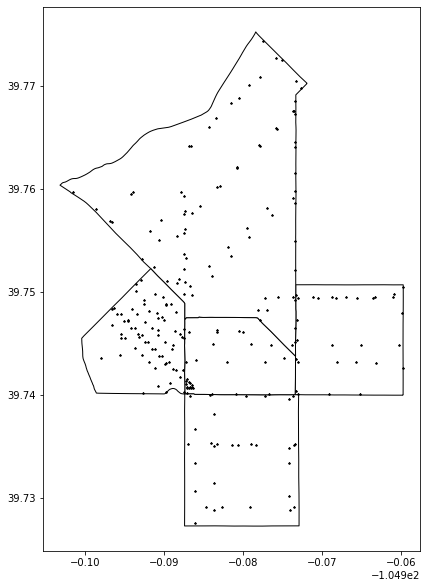

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, color = "white", edgecolor = "black")
bus_data.plot(ax = base, marker = "*", color = "black", markersize = 3)

####Lightrail Stop Data

Storing lightrail stop data.

In [29]:
lightrail_data = gpd.read_file("./lightrailstations/RTD_GIS_Current_Runboard.shp")
lightrail_data

,OBJECTID,PID,NAME,LOCAL_RTS,EXPRESS_RT,LIMITED_RT,REGIONAL_R,SKYRIDE_RT,SPECIAL_RT,ADDRESS,...,ZIPCODE,PARCEL_ID_,DIAGRAM,LOCATION,RAIL_LINE,STOPID,VMAP,CNRS,INFO_REPOR,geometry
0,80,64,Littleton / Mineral Station,402L,None,None,None,None,D,3203 W Mineral Ave,...,80120,Stop#: 24896,BroncosRide,S Santa Fe & Mineral Ave,D,33716,South Jeffco,SJFX,None,POINT (-105.02503 39.58009)
1,81,63,Littleton / Downtown Station,29-36-59-66,None,None,None,None,D,5777 S Prince St,...,80120,Stop#: 25438 (South)<br />Stop#: 24894 (North),BroncosRide,SE Corner of Alamo & Prince St,D,33715,South Jeffco,SJFX,"261 spots at station, 100 spots at S. Powers o...",POINT (-105.01488 39.61197)
2,82,65,Oxford-City of Sheridan Station,51,None,None,None,None,D,4101 Windermere St,...,80110,Stop#: 25437 (South)<br />Stop#: 24892 (North),BroncosRide,Santa Fe & Oxford,D,33726,None,None,None,POINT (-105.00482 39.64290)
3,83,1,Alameda Station,1-3-4-52,None,None,None,None,D-E-H,499 S Cherokee St,...,80223,Stop#: 23060 (South)<br />Stop#: 23042 (North),BroncosRide,Cherokee St & Alaska Pl,D-E-H,33704,Platte Valley,PLFX,None,POINT (-104.99317 39.70868)
4,84,71,18th St / California Station,None,None,None,None,None,D-H-L,1776 California St,...,80202,Stop#: 23047,None,18th St & California,D-H-L,34116,None,None,None,POINT (-104.99029 39.74660)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,152,234,Aurora Metro Center Station,3-3L-6-11-15L-21-130-133-153,None,None,None,None,R,14555 E Centrepoint Dr,...,80012,Stop#: 34580 (South)<br />Stop#: 34579 (North),None,Centrepoint & Sable,R,34678,None,None,None,POINT (-104.81915 39.70874)
73,153,125,Belleview Station,73,None,None,None,None,E-R,4855 S Quebec St,...,80237,Stop#: 25991 (South)<br />Stop#: 34010 (North),BroncosRide,Belleview & I-25,E-R,33706,Belleview,BWFX,None,POINT (-104.90457 39.62769)
74,154,175,Decatur-Federal Station,15L-16-30-31,None,None,None,None,W,1310 N Federal Blvd,...,80204,Stop#: 33958 (East)<br />Stop#: 33558 (West),BroncosRide,Colfax & Federal,W,34232,Platte Valley,PLFX,No parking during major stadium events.,POINT (-105.02407 39.73733)
75,155,233,Iliff Station,21,None,None,None,None,H-R,14030 E Iliff Ave,...,80014,Stop#: 34575 (South)<br />Stop#: 34574 (North),None,Iliff & Blackhawk,H-R,34677,None,None,This parking facility is privately owned and o...,POINT (-104.82682 39.67334)


Subsetting lightrail stops within neighborhoods of interest.

In [30]:
lightrail_data = lightrail_data.sjoin(nbrhds_of_interest)
lightrail_data

,OBJECTID,PID,NAME,LOCAL_RTS,EXPRESS_RT,LIMITED_RT,REGIONAL_R,SKYRIDE_RT,SPECIAL_RT,ADDRESS,...,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length,SHAPE_Area
4,84,71,18th St / California Station,None,None,None,None,None,D-H-L,1776 California St,...,4.0,5.0,5.0,3.7,7.872341,8.960784,10.000000,2.127659,0.042534,0.000117
9,89,72,18th St / Stout Station,None,None,None,None,None,D-H-L,1816 Stout St,...,4.0,5.0,5.0,3.7,7.872341,8.960784,10.000000,2.127659,0.042534,0.000117
48,128,69,16th St / California Station,MALL,None,None,None,None,D-H-L,1516 California St,...,4.0,5.0,5.0,3.7,7.872341,8.960784,10.000000,2.127659,0.042534,0.000117
54,134,70,16th St / Stout Station,MALL,None,None,None,None,D-H-L,1617 Stout St,...,4.0,5.0,5.0,3.7,7.872341,8.960784,10.000000,2.127659,0.042534,0.000117
57,137,67,Theatre District / Convention Center,None,None,None,None,None,D-H,1325 Stout St,...,4.0,5.0,5.0,3.7,7.872341,8.960784,10.000000,2.127659,0.042534,0.000117
5,85,74,25th St / Welton Station,None,None,None,None,None,L,2550 Welton St,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
6,86,75,27th St / Welton Station,None,None,None,None,None,L,2720 Welton St,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
8,88,57,30th / Downing Station,12-28-34,None,None,None,None,L,2999 Downing St,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
14,94,73,20th St / Welton Station,None,None,None,None,None,L,1960 Welton St,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
42,122,236,38th / Blake Station,12,None,None,None,None,A,3737 Blake St,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479


Plotting lightrail stops within neighborhoods of interest.

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


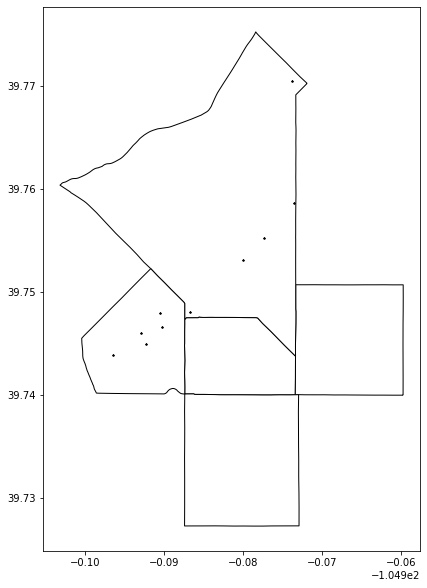

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, color = "white", edgecolor = "black")
lightrail_data.plot(ax = base, marker = "*", color = "black", markersize = 3)

##Street Data

Storing street data.

In [32]:
street_data = gpd.read_file("street_centerline.gdb", driver="OpenFileGDB")
street_data

,FNODE_,TNODE_,STREETID,MASTERID,EDITDATE,L_F_ADD,L_T_ADD,R_F_ADD,R_T_ADD,PREFIX,...,T_ZLEV,ADMINCLASS,LRSROUTE,LRSCOMMENT,LRSBGN,LRSEND,HUNDBLKNAME,LRSMAJ,SHAPE_Length,geometry
0,18880.0,3721.0,474.0,29683,20080501,3251.0,3299.0,3250.0,3298.0,,...,0,1,LARIMER ST2,LL,10545.8411,10783.7890,3250 BLK OF LARIMER ST,,0.000756,"MULTILINESTRING ((-104.97751 39.76463, -104.97..."
1,2002.0,1686.0,410.0,727,20020930,4601.0,4699.0,4600.0,4698.0,N,...,0,2,RALEIGH ST2,LR,9775.7305,10457.5299,4600 BLK OF N RALEIGH ST,,0.001872,"MULTILINESTRING ((-105.04157 39.78021, -105.04..."
2,10897.0,10896.0,875.0,16663,20020930,900.0,998.0,901.0,999.0,W,...,0,1,WMISSISSIAV,UR,2964.2211,3297.7221,900 BLK OF W MISSISSIPPI AVE,WMISSISSIAV 37,0.001185,"MULTILINESTRING ((-104.99796 39.69669, -104.99..."
3,4563.0,4562.0,283.0,14230,20040805,6501.0,6599.0,6500.0,6598.0,E,...,0,2,28TH AV5,LL,0.0000,186.2366,6500 BLK OF E 28TH AVE,,0.000662,"MULTILINESTRING ((-104.91236 39.75659, -104.91..."
4,8920.0,17825.0,725.0,27671,20170607,1100.0,1140.0,1101.0,1141.0,W,...,0,2,WBAYAUD AV4,UR,3554.1464,3750.5977,1100 BLK OF W BAYAUD AVE,,0.000698,"MULTILINESTRING ((-105.00016 39.71479, -105.00..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30470,14928.0,15076.0,730.0,10790,20020930,4400.0,4498.0,4401.0,4499.0,S,...,0,2,SZENOBIA ST7,UR,212.3430,1454.1742,4400 BLK OF S ZENOBIA ST,,0.003449,"MULTILINESTRING ((-105.05223 39.63903, -105.05..."
30471,12881.0,12879.0,962.0,9377,20180502,101.0,199.0,100.0,198.0,E,...,0,2,HARVARD AV1,UL,347.2743,672.5755,100 BLK OF E HARVARD AVE,,0.001156,"MULTILINESTRING ((-104.98635 39.67128, -104.98..."
30472,10901.0,10890.0,875.0,17038,20020930,2000.0,2198.0,2001.0,2199.0,W,...,0,1,WMISSISSIAV,UR,7112.9799,7440.9861,2000 BLK OF W MISSISSIPPI AVE,WMISSISSIAV 37,0.001166,"MULTILINESTRING ((-105.01271 39.69675, -105.01..."
30473,19674.0,19891.0,1561.0,30880,20090917,11373.0,11499.0,11372.0,11498.0,N,...,0,0,GUNCLUB RD1,LL,14280.3039,15127.9163,11372 BLK OF N GUN CLUB RD,,0.002336,"MULTILINESTRING ((-104.71478 39.90266, -104.71..."


Subsetting streets by intersecting with neighborhoods of interest.

In [33]:
street_data = street_data.sjoin(nbrhds_of_interest)
street_data

,FNODE_,TNODE_,STREETID,MASTERID,EDITDATE,L_F_ADD,L_T_ADD,R_F_ADD,R_T_ADD,PREFIX,...,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length_right,SHAPE_Area
0,18880.0,3721.0,474.0,29683,20080501,3251.0,3299.0,3250.0,3298.0,,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
48,5239.0,5191.0,494.0,21196,20180502,400.0,498.0,401.0,499.0,,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
49,3848.0,3756.0,461.0,24846,20020930,3001.0,3099.0,3000.0,3098.0,,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
62,4492.0,4390.0,480.0,24924,20020930,2701.0,2799.0,2700.0,2798.0,,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
85,4865.0,4721.0,478.0,3063,20020930,2301.0,2399.0,2300.0,2398.0,,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29493,5849.0,5848.0,17.0,16839,20180502,1401.0,1599.0,1400.0,1598.0,E,...,2.0,1.0,4.0,2.5,5.319149,7.714286,8.608940,3.289791,0.048647,0.000146
29939,5166.0,5043.0,345.0,3302,20020930,2301.0,2399.0,2300.0,2398.0,N,...,2.0,1.0,4.0,2.5,5.319149,7.714286,8.608940,3.289791,0.048647,0.000146
30117,5360.0,5264.0,335.0,3479,20020930,2101.0,2199.0,2100.0,2198.0,N,...,2.0,1.0,4.0,2.5,5.319149,7.714286,8.608940,3.289791,0.048647,0.000146
30230,6405.0,6256.0,346.0,20791,20020930,1401.0,1499.0,1400.0,1498.0,N,...,2.0,1.0,4.0,2.5,5.319149,7.714286,8.608940,3.289791,0.048647,0.000146


Plotting streets within neighborhoods of interest with key destinations and crashes.

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


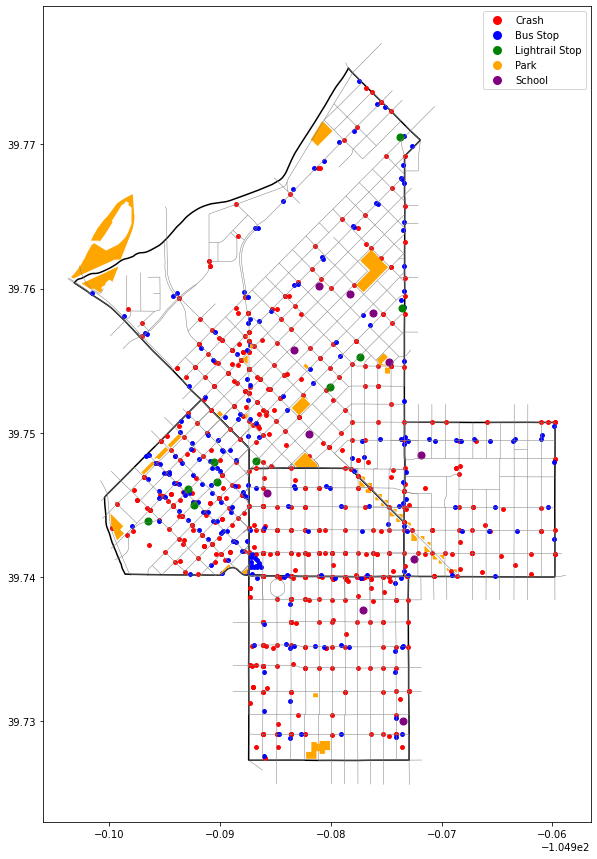

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15), facecolor="white")

legend = [line.Line2D([0],[0],marker='o',color='w',label='Crash', markerfacecolor='red', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='Bus Stop', markerfacecolor='blue', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='Lightrail Stop', markerfacecolor='green', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='Park', markerfacecolor='orange', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='School', markerfacecolor='purple', markersize=10)]
ax.legend(handles=legend)

base = nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, color="white", edgecolor="black", linewidth=1.5)
street_data.plot(ax = base, color = "grey", linewidth = 0.5)
crash_data.plot(ax = base, marker = "o", color = "red", markersize = 15)
bus_data.plot(ax = base, marker = "o", color = "blue", markersize = 15)
lightrail_data.plot(ax = base, marker = "o", color = "green", markersize = 50)
park_data.plot(ax = base, color = "orange")
school_data.plot(ax = base, color = "purple", markersize = 50)

Creating 1/4 mile buffer around street data.

In [35]:
#given one degree of latitude ~= 69 miles, and
#one degree of longitude at 40 degrees north ~= 53 miles
buff = (1 / ((69 + 53) / 2)) / 4 #1/4 mile in degrees of lat/long

street_buffers = street_data.copy()
street_buffers["geometry"] = street_buffers["geometry"].buffer(buff)
street_buffers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


,FNODE_,TNODE_,STREETID,MASTERID,EDITDATE,L_F_ADD,L_T_ADD,R_F_ADD,R_T_ADD,PREFIX,...,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length_right,SHAPE_Area
0,18880.0,3721.0,474.0,29683,20080501,3251.0,3299.0,3250.0,3298.0,,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
48,5239.0,5191.0,494.0,21196,20180502,400.0,498.0,401.0,499.0,,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
49,3848.0,3756.0,461.0,24846,20020930,3001.0,3099.0,3000.0,3098.0,,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
62,4492.0,4390.0,480.0,24924,20020930,2701.0,2799.0,2700.0,2798.0,,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
85,4865.0,4721.0,478.0,3063,20020930,2301.0,2399.0,2300.0,2398.0,,...,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29493,5849.0,5848.0,17.0,16839,20180502,1401.0,1599.0,1400.0,1598.0,E,...,2.0,1.0,4.0,2.5,5.319149,7.714286,8.608940,3.289791,0.048647,0.000146
29939,5166.0,5043.0,345.0,3302,20020930,2301.0,2399.0,2300.0,2398.0,N,...,2.0,1.0,4.0,2.5,5.319149,7.714286,8.608940,3.289791,0.048647,0.000146
30117,5360.0,5264.0,335.0,3479,20020930,2101.0,2199.0,2100.0,2198.0,N,...,2.0,1.0,4.0,2.5,5.319149,7.714286,8.608940,3.289791,0.048647,0.000146
30230,6405.0,6256.0,346.0,20791,20020930,1401.0,1499.0,1400.0,1498.0,N,...,2.0,1.0,4.0,2.5,5.319149,7.714286,8.608940,3.289791,0.048647,0.000146


Plotting streets with buffers.

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


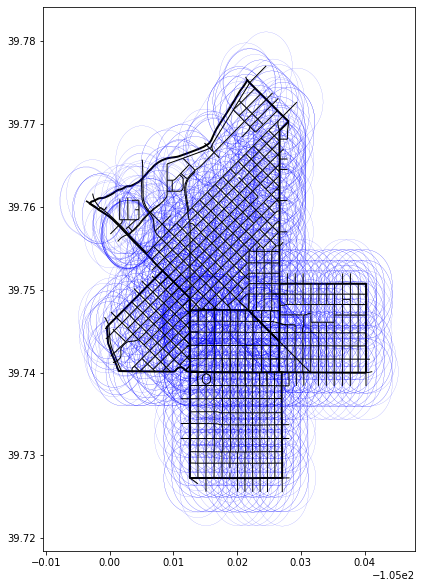

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, color="white", edgecolor="black", linewidth=2)
street_data.plot(ax = base, color = "black", linewidth = 1)
street_buffers.plot(ax = base, color = "none", edgecolor = "blue", linewidth = 0.1)

##Crashes and Key Destinations near Streets

Removing "index_right" columns from each data set so they can be merged again.

In [37]:
crash_data = crash_data.drop(["index_right"], axis = 1)
park_data = park_data.drop(["index_right"], axis = 1)
school_data = school_data.drop(["index_right"], axis = 1)
bus_data = bus_data.drop(["index_right"], axis = 1)
lightrail_data = lightrail_data.drop(["index_right"], axis = 1)
street_buffers = street_buffers.drop(["index_right"], axis = 1)
street_data = street_data.drop(["index_right"], axis = 1)

###North Capitol Hill

Subsetting streets within North Capitol Hill.

In [38]:
nch_streets = street_data.sjoin(nbrhds_of_interest.iloc[[0]])
nch_streets

,FNODE_,TNODE_,STREETID,MASTERID,EDITDATE,L_F_ADD,L_T_ADD,R_F_ADD,R_T_ADD,PREFIX,...,MORBIDITY_SCORE_right,MORTALITY_SCORE_right,BUILTENV_SCORE_right,OVERALLEQUITY_SCORE_right,EQUITY_SCORE_10_right,AVG_PDI_SCORE_right,AVG_PDI_10_right,PDI_EQUITY_DIFF_right,SHAPE_Length,SHAPE_Area_right
1403,5686.0,5603.0,592.0,21205,20130321,1800.0,1888.0,1801.0,1889.0,,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
1662,5456.0,5395.0,512.0,22027,20050804,350.0,398.0,351.0,399.0,,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
2190,30176.0,18424.0,494.0,21199,20060831,100.0,228.0,101.0,229.0,,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
3119,5457.0,5395.0,359.0,22026,20050804,2001.0,2099.0,2000.0,2098.0,N,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
6192,5459.0,30176.0,317.0,19583,20020930,677.0,699.0,700.0,748.0,E,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6095,6023.0,5851.0,339.0,19380,20180502,1601.0,1699.0,1600.0,1698.0,N,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
10987,5851.0,5779.0,339.0,19379,20040607,1701.0,1737.0,1700.0,1738.0,N,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
25453,5779.0,5686.0,592.0,21202,20180502,1722.0,1798.0,1723.0,1799.0,,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
28818,5855.0,5851.0,17.0,3765,20180502,1001.0,1099.0,1000.0,1098.0,E,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096


Creating 1/4 mile buffers around nch_streets.

In [39]:
nch_buffers = nch_streets.copy()
nch_buffers["geometry"] = nch_buffers["geometry"].buffer(buff)
nch_buffers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


,FNODE_,TNODE_,STREETID,MASTERID,EDITDATE,L_F_ADD,L_T_ADD,R_F_ADD,R_T_ADD,PREFIX,...,MORBIDITY_SCORE_right,MORTALITY_SCORE_right,BUILTENV_SCORE_right,OVERALLEQUITY_SCORE_right,EQUITY_SCORE_10_right,AVG_PDI_SCORE_right,AVG_PDI_10_right,PDI_EQUITY_DIFF_right,SHAPE_Length,SHAPE_Area_right
1403,5686.0,5603.0,592.0,21205,20130321,1800.0,1888.0,1801.0,1889.0,,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
1662,5456.0,5395.0,512.0,22027,20050804,350.0,398.0,351.0,399.0,,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
2190,30176.0,18424.0,494.0,21199,20060831,100.0,228.0,101.0,229.0,,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
3119,5457.0,5395.0,359.0,22026,20050804,2001.0,2099.0,2000.0,2098.0,N,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
6192,5459.0,30176.0,317.0,19583,20020930,677.0,699.0,700.0,748.0,E,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6095,6023.0,5851.0,339.0,19380,20180502,1601.0,1699.0,1600.0,1698.0,N,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
10987,5851.0,5779.0,339.0,19379,20040607,1701.0,1737.0,1700.0,1738.0,N,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
25453,5779.0,5686.0,592.0,21202,20180502,1722.0,1798.0,1723.0,1799.0,,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
28818,5855.0,5851.0,17.0,3765,20180502,1001.0,1099.0,1000.0,1098.0,E,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096


Subsetting crashes within NCH.

In [40]:
nch_crashes = crash_data.sjoin(nbrhds_of_interest.iloc[[0]])
nch_crashes

,OBJECTID_1,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,TOP_TRAFFIC_ACCIDENT_OFFENSE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,...,MORBIDITY_SCORE_right,MORTALITY_SCORE_right,BUILTENV_SCORE_right,OVERALLEQUITY_SCORE_right,EQUITY_SCORE_10_right,AVG_PDI_SCORE_right,AVG_PDI_10_right,PDI_EQUITY_DIFF_right,SHAPE_Length_right,SHAPE_Area_right
1920,1921.0,2017173499,201717349954010,5401,0,TRAF - ACCIDENT - HIT & RUN,N LINCOLN ST / E 16TH AVE,3144511.0,1695445.0,-104.986117,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
2579,2580.0,2017194401,201719440154010,5401,0,TRAF - ACCIDENT - HIT & RUN,E 16TH AVE / N LOGAN ST,3145575.0,1695450.0,-104.982334,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
3071,3072.0,201721070,20172107054410,5441,0,TRAF - ACCIDENT,PARK AVE / N DOWNING ST,3148087.0,1696230.0,-104.973385,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
4457,4458.0,2017256365,201725636554410,5441,0,TRAF - ACCIDENT,E 16TH AVE / N SHERMAN ST,3144866.0,1695446.0,-104.984855,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
5264,5265.0,2017282407,201728240754410,5441,0,TRAF - ACCIDENT,E 16TH AVE / N PENNSYLVANIA ST,3145925.0,1695452.0,-104.981089,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97349,97350.0,2021317230,202131723054411,5441,1,TRAF - ACCIDENT - SBI,E 19TH AVE / N PENNSYLVANIA ST,3145917.0,1697093.0,-104.981084,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
97558,97559.0,2021325561,202132556154010,5401,0,TRAF - ACCIDENT - HIT & RUN,N OGDEN ST / E COLFAX AVE,3147550.0,1694859.0,-104.975323,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
105101,105102.0,2021590648,202159064854411,5441,1,TRAF - ACCIDENT - SBI,PARK AVE / E 20TH AVE,3146731.0,1697578.0,-104.978179,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
105984,105985.0,2021617353,202161735354411,5441,1,TRAF - ACCIDENT - SBI,E 17TH AVE / N PENNSYLVANIA ST,3145923.0,1696033.0,-104.981084,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096


Calculating the percentage of crashes within each street buffer in NCH.

In [41]:
nch_crashes = nch_crashes.drop(["index_right"], axis = 1)
nch_buffers = nch_buffers.drop(["index_right"], axis = 1)

nch_street_crashes = [0] * len(nch_buffers)

for i in range(len(nch_buffers)):
  newdat = nch_crashes.sjoin(nch_buffers.iloc[[i]])
  nch_street_crashes[i] = len(newdat) / len(nch_crashes);

Subsetting all Key Destination data within NCH.

In [42]:
#subsetting data
nch_parks = park_data.sjoin(nbrhds_of_interest.iloc[[0]])
nch_schools = school_data.sjoin(nbrhds_of_interest.iloc[[0]])
nch_bus_stops = bus_data.sjoin(nbrhds_of_interest.iloc[[0]])
nch_lightrail_stops = lightrail_data.sjoin(nbrhds_of_interest.iloc[[0]])

Calculating the percentage of parks within each street buffer in NCH.

In [43]:
nch_parks = nch_parks.drop(["index_right"], axis = 1)

nch_street_parks = [0] * len(nch_buffers)

for i in range(len(nch_buffers)):
  newdat = nch_parks.sjoin(nch_buffers.iloc[[i]])
  nch_street_parks[i] = len(newdat) / len(nch_parks);

Calculating the percentage of schools within each street buffer in NCH.

In [44]:
nch_schools = nch_schools.drop(["index_right"], axis = 1)

nch_street_schools = [0] * len(nch_buffers)

for i in range(len(nch_buffers)):
  newdat = nch_schools.sjoin(nch_buffers.iloc[[i]])
  nch_street_schools[i] = len(newdat) / len(nch_schools);

Calculating the percentage of bus stops within each street buffer in NCH.

In [45]:
nch_bus_stops = nch_bus_stops.drop(["index_right"], axis = 1)

nch_street_bus_stops = [0] * len(nch_buffers)

for i in range(len(nch_buffers)):
  newdat = nch_bus_stops.sjoin(nch_buffers.iloc[[i]])
  nch_street_bus_stops[i] = len(newdat) / len(nch_bus_stops);

There are no lightrail stops in NCH, so that will not be calculated.

Summing together the percentage of crashes and key destinations within each street buffer, and adding that to "nch_streets". Therefore, the streets most heavily weighted will be those that have the highest percentage of all of these, weighted equally.

In [46]:
nch_events = [0] * len(nch_buffers)

for i in range(len(nch_buffers)):
  nch_events[i] = nch_street_crashes[i] + nch_street_parks[i] + nch_street_schools[i] + nch_street_bus_stops[i]

nch_streets.insert(1, "NCH_EVENTS", nch_events, False)

best_nch_streets = nch_streets.sort_values(by = ["NCH_EVENTS"], ascending = False)[0:5]

Printing names of best NCH streets.

In [47]:
for i in range(len(best_nch_streets)):
  print("Street", i+1)
  print(best_nch_streets.FULLNAME.iloc[i], "from", best_nch_streets.FROMNAME.iloc[i], "to", best_nch_streets.TONAME.iloc[i])

Street 1
E 18TH AVE from N LOGAN ST/TRAFFIC SIGNAL to N PENNSYLVANIA ST
Street 2
E 19TH AVE from N LOGAN ST/TRAFFIC SIGNAL to N PENNSYLVANIA ST
Street 3
E 20TH AVE from N LOGAN ST/TRAFFIC SIGNAL to 22ND ST/N PENNSYLVANIA ST
Street 4
E 17TH AVE from N SHERMAN ST/TRAFFIC SIGNAL to N GRANT ST/TRAFFIC SIGNAL
Street 5
N GRANT ST from E 16TH AVE/TRAFFIC SIGNAL to E 17TH AVE/TRAFFIC SIGNAL


Plotting best streets in NCH.

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


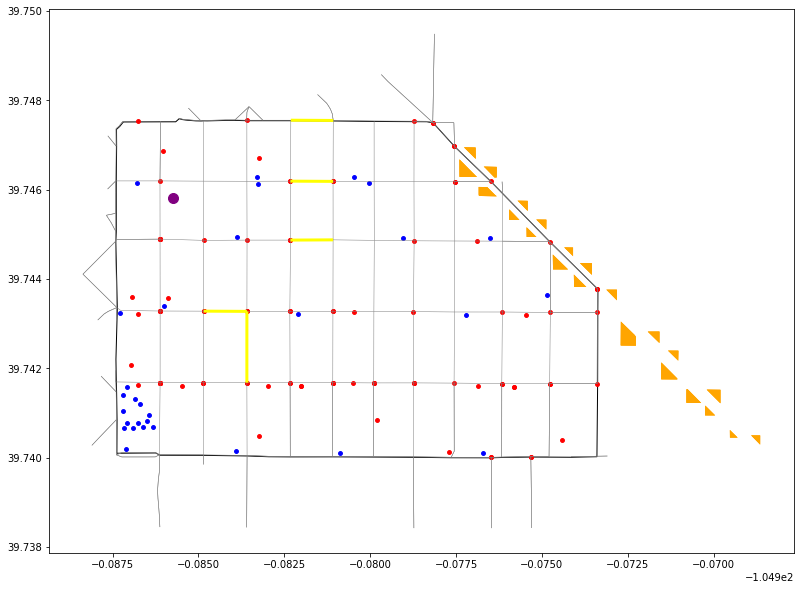

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.iloc[[0]].plot(column="NBRHD_NAME", ax=ax, color="white", edgecolor="black", linewidth=1)
nch_streets.plot(ax = base, color = "grey", linewidth = 0.5)
best_nch_streets.plot(ax = base, color = "yellow", linewidth = 3)
nch_crashes.plot(ax = base, marker = "o", color = "red", markersize = 15)
nch_bus_stops.plot(ax = base, marker = "o", color = "blue", markersize = 15)
nch_lightrail_stops.plot(ax = base, marker = "o", color = "green", markersize = 50)
nch_parks.plot(ax = base, color = "orange")
nch_schools.plot(ax = base, color = "purple", markersize = 100)

###City Park West

Subsetting streets within City Park West.

In [49]:
cpw_streets = street_data.sjoin(nbrhds_of_interest.iloc[[1]])

Creating 1/4 mile buffers around cpw_streets.

In [50]:
cpw_buffers = cpw_streets.copy()
cpw_buffers["geometry"] = cpw_buffers["geometry"].buffer(buff)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


Subsetting crashes within CPW.

In [51]:
cpw_crashes = crash_data.sjoin(nbrhds_of_interest.iloc[[1]])

Calculating the percentage of crashes within each street buffer in CPW.

In [52]:
cpw_crashes = cpw_crashes.drop(["index_right"], axis = 1)
cpw_buffers = cpw_buffers.drop(["index_right"], axis = 1)

cpw_street_crashes = [0] * len(cpw_buffers)

for i in range(len(cpw_buffers)):
  newdat = cpw_crashes.sjoin(cpw_buffers.iloc[[i]])
  cpw_street_crashes[i] = len(newdat) / len(cpw_crashes);

Subsetting all Key Destination data within CPW.

In [53]:
#subsetting data
cpw_parks = park_data.sjoin(nbrhds_of_interest.iloc[[1]])
cpw_schools = school_data.sjoin(nbrhds_of_interest.iloc[[1]])
cpw_bus_stops = bus_data.sjoin(nbrhds_of_interest.iloc[[1]])
cpw_lightrail_stops = lightrail_data.sjoin(nbrhds_of_interest.iloc[[1]])

Calculating the percentage of parks within each street buffer in CPW.

In [54]:
cpw_parks = cpw_parks.drop(["index_right"], axis = 1)

cpw_street_parks = [0] * len(cpw_buffers)

for i in range(len(cpw_buffers)):
  newdat = cpw_parks.sjoin(cpw_buffers.iloc[[i]])
  cpw_street_parks[i] = len(newdat) / len(cpw_parks);

Calculating the percentage of schools within each street buffer in CPW.

In [55]:
cpw_schools = cpw_schools.drop(["index_right"], axis = 1)

cpw_street_schools = [0] * len(cpw_buffers)

for i in range(len(cpw_buffers)):
  newdat = cpw_schools.sjoin(cpw_buffers.iloc[[i]])
  cpw_street_schools[i] = len(newdat) / len(cpw_schools);

Calculating the percentage of bus stops within each street buffer in CPW.

In [56]:
cpw_bus_stops = cpw_bus_stops.drop(["index_right"], axis = 1)

cpw_street_bus_stops = [0] * len(cpw_buffers)

for i in range(len(cpw_buffers)):
  newdat = cpw_bus_stops.sjoin(cpw_buffers.iloc[[i]])
  cpw_street_bus_stops[i] = len(newdat) / len(cpw_bus_stops);

There are no lightrail stops in CPW, so that will not be calculated.

Summing together the percentage of crashes and key destinations within each street buffer, and adding that to "cpw_streets". Therefore, the streets most heavily weighted will be those that have the highest percentage of all of these, weighted equally.

In [57]:
cpw_events = [0] * len(cpw_buffers)

for i in range(len(cpw_buffers)):
  cpw_events[i] = cpw_street_crashes[i] + cpw_street_parks[i] + cpw_street_schools[i] + cpw_street_bus_stops[i]

cpw_streets.insert(1, "CPW_EVENTS", cpw_events, False)

best_cpw_streets = cpw_streets.sort_values(by = ["CPW_EVENTS"], ascending = False)[0:5]

Printing names of best CPW streets.

In [58]:
for i in range(len(best_cpw_streets)):
  print("Street", i+1)
  print(best_cpw_streets.FULLNAME.iloc[i], "from", best_cpw_streets.FROMNAME.iloc[i], "to", best_cpw_streets.TONAME.iloc[i])

Street 1
N LAFAYETTE ST from E 17TH AVE to E 18TH AVE/TRAFFIC SIGNAL
Street 2
E 18TH AVE from N LAFAYETTE ST/TRAFFIC SIGNAL to N HUMBOLDT ST
Street 3
N LAFAYETTE ST from E 18TH AVE/TRAFFIC SIGNAL to E 19TH AVE/NMCHG
Street 4
N MARION ST from E 17TH AVE to E 18TH AVE
Street 5
E 18TH AVE from N MARION ST to N LAFAYETTE ST/TRAFFIC SIGNAL


Plotting best streets in CPW.

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


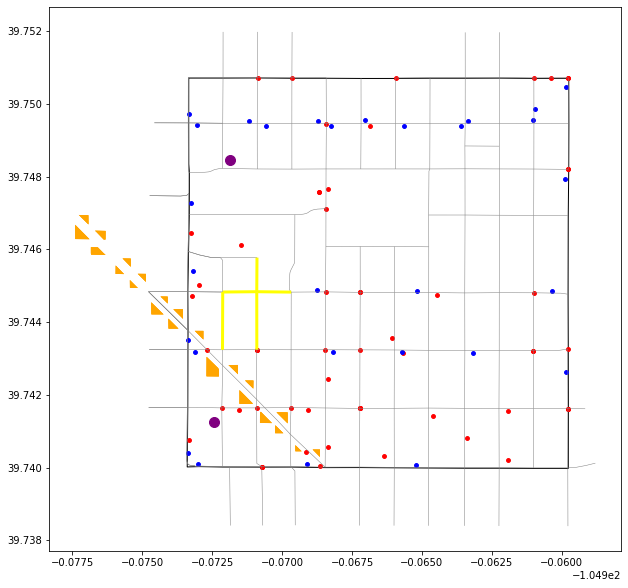

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.iloc[[1]].plot(column="NBRHD_NAME", ax=ax, color="white", edgecolor="black", linewidth=1)
cpw_streets.plot(ax = base, color = "grey", linewidth = 0.5)
best_cpw_streets.plot(ax = base, color = "yellow", linewidth = 3)
cpw_crashes.plot(ax = base, marker = "o", color = "red", markersize = 15)
cpw_bus_stops.plot(ax = base, marker = "o", color = "blue", markersize = 15)
cpw_lightrail_stops.plot(ax = base, marker = "o", color = "green", markersize = 50)
cpw_parks.plot(ax = base, color = "orange")
cpw_schools.plot(ax = base, color = "purple", markersize = 100)

###Capitol Hill

Subsetting streets within Capitol Hill.

In [60]:
ch_streets = street_data.sjoin(nbrhds_of_interest.iloc[[2]])

Creating 1/4 mile buffers around ch_streets.

In [61]:
ch_buffers = ch_streets.copy()
ch_buffers["geometry"] = ch_buffers["geometry"].buffer(buff)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


Subsetting crashes within CH.

In [62]:
ch_crashes = crash_data.sjoin(nbrhds_of_interest.iloc[[2]])

Calculating the percentage of crashes within each street buffer in CH.

In [63]:
ch_crashes = ch_crashes.drop(["index_right"], axis = 1)
ch_buffers = ch_buffers.drop(["index_right"], axis = 1)

ch_street_crashes = [0] * len(ch_buffers)

for i in range(len(ch_buffers)):
  newdat = ch_crashes.sjoin(ch_buffers.iloc[[i]])
  ch_street_crashes[i] = len(newdat) / len(ch_crashes);

Subsetting all Key Destination data within CH.

In [70]:
#subsetting data
ch_parks = park_data.sjoin(nbrhds_of_interest.iloc[[2]])
ch_schools = school_data.sjoin(nbrhds_of_interest.iloc[[2]])
ch_bus_stops = bus_data.sjoin(nbrhds_of_interest.iloc[[2]])
ch_lightrail_stops = lightrail_data.sjoin(nbrhds_of_interest.iloc[[2]])

Calculating the percentage of parks within each street buffer in CH.

In [71]:
ch_parks = ch_parks.drop(["index_right"], axis = 1)

ch_street_parks = [0] * len(ch_buffers)

for i in range(len(ch_buffers)):
  newdat = ch_parks.sjoin(ch_buffers.iloc[[i]])
  ch_street_parks[i] = len(newdat) / len(ch_parks);

Calculating the percentage of schools within each street buffer in CH.

In [72]:
ch_schools = ch_schools.drop(["index_right"], axis = 1)

ch_street_schools = [0] * len(ch_buffers)

for i in range(len(ch_buffers)):
  newdat = ch_schools.sjoin(ch_buffers.iloc[[i]])
  ch_street_schools[i] = len(newdat) / len(ch_schools);

Calculating the percentage of bus stops within each street buffer in CH.

In [73]:
ch_bus_stops = ch_bus_stops.drop(["index_right"], axis = 1)

ch_street_bus_stops = [0] * len(ch_buffers)

for i in range(len(ch_buffers)):
  newdat = ch_bus_stops.sjoin(ch_buffers.iloc[[i]])
  ch_street_bus_stops[i] = len(newdat) / len(ch_bus_stops);

There are no lightrail stops in CH, so that will not be calculated.

Summing together the percentage of crashes and key destinations within each street buffer, and adding that to "ch_streets". Therefore, the streets most heavily weighted will be those that have the highest percentage of all of these, weighted equally.

In [75]:
ch_events = [0] * len(ch_buffers)

for i in range(len(ch_buffers)):
  ch_events[i] = ch_street_crashes[i] + ch_street_parks[i] + ch_street_schools[i] + ch_street_bus_stops[i]

ch_streets.insert(1, "CH_EVENTS", ch_events, False)

best_ch_streets = ch_streets.sort_values(by = ["CH_EVENTS"], ascending = False)[0:5]

Printing names of best CH streets.

In [76]:
for i in range(len(best_ch_streets)):
  print("Street", i+1)
  print(best_ch_streets.FULLNAME.iloc[i], "from", best_ch_streets.FROMNAME.iloc[i], "to", best_ch_streets.TONAME.iloc[i])

Street 1
N CLARKSON ST from E 9TH AVE to E 10TH AVE
Street 2
E 9TH AVE from N CLARKSON ST to N EMERSON ST
Street 3
N CLARKSON ST from E 8TH AVE/TRAFFIC SIGNAL to E 9TH AVE
Street 4
E 9TH AVE from N WASHINGTON ST to N CLARKSON ST
Street 5
N LOGAN ST from E 10TH AVE/TRAFFIC SIGNAL to E 11TH AVE/TRAFFIC SIGNAL


Plotting best streets in CH.

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning
/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


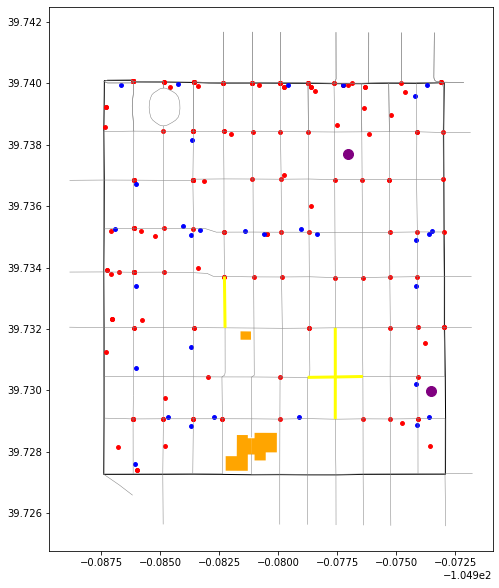

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.iloc[[2]].plot(column="NBRHD_NAME", ax=ax, color="white", edgecolor="black", linewidth=1)
ch_streets.plot(ax = base, color = "grey", linewidth = 0.5)
best_ch_streets.plot(ax = base, color = "yellow", linewidth = 3)
ch_crashes.plot(ax = base, marker = "o", color = "red", markersize = 15)
ch_bus_stops.plot(ax = base, marker = "o", color = "blue", markersize = 15)
ch_lightrail_stops.plot(ax = base, marker = "o", color = "green", markersize = 50)
ch_parks.plot(ax = base, color = "orange")
ch_schools.plot(ax = base, color = "purple", markersize = 100)

###Five Points

Subsetting streets within Five Points.

In [78]:
fp_streets = street_data.sjoin(nbrhds_of_interest.iloc[[3]])

Creating 1/4 mile buffers around fp_streets.

In [79]:
fp_buffers = fp_streets.copy()
fp_buffers["geometry"] = fp_buffers["geometry"].buffer(buff)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


Subsetting crashes within FP.

In [80]:
fp_crashes = crash_data.sjoin(nbrhds_of_interest.iloc[[3]])

Calculating the percentage of crashes within each street buffer in FP.

In [81]:
fp_crashes = fp_crashes.drop(["index_right"], axis = 1)
fp_buffers = fp_buffers.drop(["index_right"], axis = 1)

fp_street_crashes = [0] * len(fp_buffers)

for i in range(len(fp_buffers)):
  newdat = fp_crashes.sjoin(fp_buffers.iloc[[i]])
  fp_street_crashes[i] = len(newdat) / len(fp_crashes);

Subsetting all Key Destination data within FP.

In [82]:
#subsetting data
fp_parks = park_data.sjoin(nbrhds_of_interest.iloc[[3]])
fp_schools = school_data.sjoin(nbrhds_of_interest.iloc[[3]])
fp_bus_stops = bus_data.sjoin(nbrhds_of_interest.iloc[[3]])
fp_lightrail_stops = lightrail_data.sjoin(nbrhds_of_interest.iloc[[3]])

Calculating the percentage of parks within each street buffer in FP.

In [83]:
fp_parks = fp_parks.drop(["index_right"], axis = 1)

fp_street_parks = [0] * len(fp_buffers)

for i in range(len(fp_buffers)):
  newdat = fp_parks.sjoin(fp_buffers.iloc[[i]])
  fp_street_parks[i] = len(newdat) / len(fp_parks);

Calculating the percentage of schools within each street buffer in FP.

In [84]:
fp_schools = fp_schools.drop(["index_right"], axis = 1)

fp_street_schools = [0] * len(fp_buffers)

for i in range(len(fp_buffers)):
  newdat = fp_schools.sjoin(fp_buffers.iloc[[i]])
  fp_street_schools[i] = len(newdat) / len(fp_schools);

Calculating the percentage of bus stops within each street buffer in FP.

In [85]:
fp_bus_stops = fp_bus_stops.drop(["index_right"], axis = 1)

fp_street_bus_stops = [0] * len(fp_buffers)

for i in range(len(fp_buffers)):
  newdat = fp_bus_stops.sjoin(fp_buffers.iloc[[i]])
  fp_street_bus_stops[i] = len(newdat) / len(fp_bus_stops);

Calculating the percentage of lightrail stops within each street buffer in FP.

In [86]:
fp_lightrail_stops = fp_lightrail_stops.drop(["index_right"], axis = 1)

fp_street_lightrail_stops = [0] * len(fp_buffers)

for i in range(len(fp_buffers)):
  newdat = fp_lightrail_stops.sjoin(fp_buffers.iloc[[i]])
  fp_street_lightrail_stops[i] = len(newdat) / len(fp_lightrail_stops);

Summing together the percentage of crashes and key destinations within each street buffer, and adding that to "fp_streets". Therefore, the streets most heavily weighted will be those that have the highest percentage of all of these, weighted equally.

In [87]:
fp_events = [0] * len(fp_buffers)

for i in range(len(fp_buffers)):
  fp_events[i] = fp_street_crashes[i] + fp_street_parks[i] + fp_street_schools[i] + fp_street_bus_stops[i] + fp_street_lightrail_stops[i]

fp_streets.insert(1, "FP_EVENTS", fp_events, False)

best_fp_streets = fp_streets.sort_values(by = ["FP_EVENTS"], ascending = False)[0:5]

Printing names of best FP streets.

In [88]:
for i in range(len(best_fp_streets)):
  print("Street", i+1)
  print(best_fp_streets.FULLNAME.iloc[i], "from", best_fp_streets.FROMNAME.iloc[i], "to", best_fp_streets.TONAME.iloc[i])

Street 1
CALIFORNIA ST from 28TH ST to 29TH ST
Street 2
STOUT ST from 27TH ST to 28TH ST/TRAFFIC SIGNAL
Street 3
28TH ST from CALIFORNIA ST to STOUT ST/TRAFFIC SIGNAL
Street 4
CALIFORNIA ST from 22ND ST to PARK AVE W/TRAFFIC SIGNAL
Street 5
CALIFORNIA ST from 27TH ST to 28TH ST


Plotting best streets in FP.

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


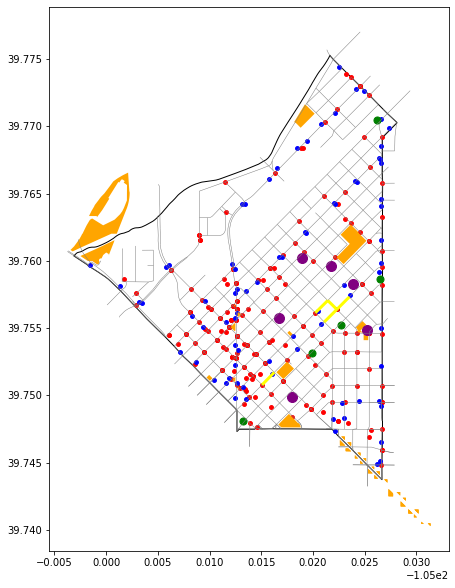

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.iloc[[3]].plot(column="NBRHD_NAME", ax=ax, color="white", edgecolor="black", linewidth=1)
fp_streets.plot(ax = base, color = "grey", linewidth = 0.5)
best_fp_streets.plot(ax = base, color = "yellow", linewidth = 3)
fp_crashes.plot(ax = base, marker = "o", color = "red", markersize = 15)
fp_bus_stops.plot(ax = base, marker = "o", color = "blue", markersize = 15)
fp_lightrail_stops.plot(ax = base, marker = "o", color = "green", markersize = 50)
fp_parks.plot(ax = base, color = "orange")
fp_schools.plot(ax = base, color = "purple", markersize = 100)

###Central Business District

Subsetting streets within Central Business District.

In [90]:
cbd_streets = street_data.sjoin(nbrhds_of_interest.iloc[[4]])

Creating 1/4 mile buffers around cbd_streets.

In [91]:
cbd_buffers = cbd_streets.copy()
cbd_buffers["geometry"] = cbd_buffers["geometry"].buffer(buff)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


Subsetting crashes within CBD.

In [92]:
cbd_crashes = crash_data.sjoin(nbrhds_of_interest.iloc[[4]])

Calculating the percentage of crashes within each street buffer in CBD.

In [93]:
cbd_crashes = cbd_crashes.drop(["index_right"], axis = 1)
cbd_buffers = cbd_buffers.drop(["index_right"], axis = 1)

cbd_street_crashes = [0] * len(cbd_buffers)

for i in range(len(cbd_buffers)):
  newdat = cbd_crashes.sjoin(cbd_buffers.iloc[[i]])
  cbd_street_crashes[i] = len(newdat) / len(cbd_crashes);

Subsetting all Key Destination data within CBD.

In [94]:
#subsetting data
cbd_parks = park_data.sjoin(nbrhds_of_interest.iloc[[4]])
cbd_schools = school_data.sjoin(nbrhds_of_interest.iloc[[4]])
cbd_bus_stops = bus_data.sjoin(nbrhds_of_interest.iloc[[4]])
cbd_lightrail_stops = lightrail_data.sjoin(nbrhds_of_interest.iloc[[4]])

Calculating the percentage of parks within each street buffer in CBD.

In [95]:
cbd_parks = cbd_parks.drop(["index_right"], axis = 1)

cbd_street_parks = [0] * len(cbd_buffers)

for i in range(len(cbd_buffers)):
  newdat = cbd_parks.sjoin(cbd_buffers.iloc[[i]])
  cbd_street_parks[i] = len(newdat) / len(cbd_parks);

There are no schools in CBD, so that will not be calculated.

Calculating the percentage of bus stops within each street buffer in CBD.

In [96]:
cbd_bus_stops = cbd_bus_stops.drop(["index_right"], axis = 1)

cbd_street_bus_stops = [0] * len(cbd_buffers)

for i in range(len(cbd_buffers)):
  newdat = cbd_bus_stops.sjoin(cbd_buffers.iloc[[i]])
  cbd_street_bus_stops[i] = len(newdat) / len(cbd_bus_stops);

Calculating the percentage of lightrail stops within each street buffer in CBD.

In [97]:
cbd_lightrail_stops = cbd_lightrail_stops.drop(["index_right"], axis = 1)

cbd_street_lightrail_stops = [0] * len(cbd_buffers)

for i in range(len(cbd_buffers)):
  newdat = cbd_lightrail_stops.sjoin(cbd_buffers.iloc[[i]])
  cbd_street_lightrail_stops[i] = len(newdat) / len(cbd_lightrail_stops);

Summing together the percentage of crashes and key destinations within each street buffer, and adding that to "cbd_streets". Therefore, the streets most heavily weighted will be those that have the highest percentage of all of these, weighted equally.

In [98]:
cbd_events = [0] * len(cbd_buffers)

for i in range(len(cbd_buffers)):
  cbd_events[i] = cbd_street_crashes[i] + cbd_street_parks[i] + cbd_street_bus_stops[i] + cbd_street_lightrail_stops[i]

cbd_streets.insert(1, "CBD_EVENTS", cbd_events, False)

best_cbd_streets = cbd_streets.sort_values(by = ["CBD_EVENTS"], ascending = False)[0:5]

Printing names of best CBD streets.

In [99]:
for i in range(len(best_cbd_streets)):
  print("Street", i+1)
  print(best_cbd_streets.FULLNAME.iloc[i], "from", best_cbd_streets.FROMNAME.iloc[i], "to", best_cbd_streets.TONAME.iloc[i])

Street 1
STOUT ST from 16TH ST/TRAFFIC SIGNAL to 17TH ST/TRAFFIC SIGNAL
Street 2
16TH ST from CALIFORNIA ST/TRAFFIC SIGNAL to STOUT ST/TRAFFIC SIGNAL
Street 3
CHAMPA ST from 16TH ST/TRAFFIC SIGNAL to 17TH ST/TRAFFIC SIGNAL
Street 4
16TH ST from STOUT ST/TRAFFIC SIGNAL to CHAMPA ST/TRAFFIC SIGNAL
Street 5
STOUT ST from 15TH ST/TRAFFIC SIGNAL to 16TH ST/TRAFFIC SIGNAL


Plotting best streets in CBD.

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


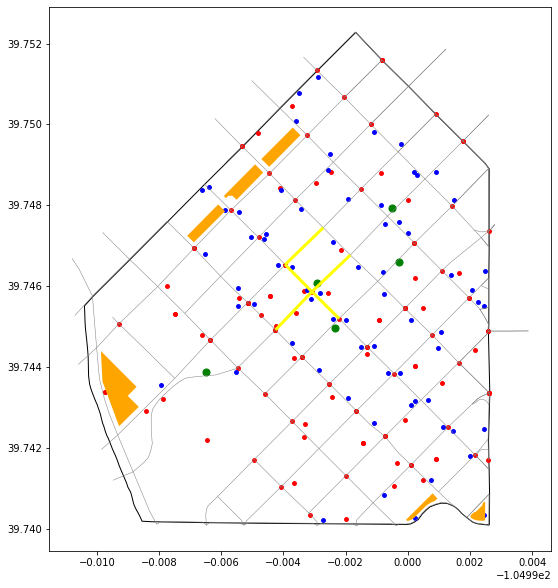

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10), facecolor="white")
base = nbrhds_of_interest.iloc[[4]].plot(column="NBRHD_NAME", ax=ax, color="white", edgecolor="black", linewidth=1)
cbd_streets.plot(ax = base, color = "grey", linewidth = 0.5)
best_cbd_streets.plot(ax = base, color = "yellow", linewidth = 3)
cbd_crashes.plot(ax = base, marker = "o", color = "red", markersize = 15)
cbd_bus_stops.plot(ax = base, marker = "o", color = "blue", markersize = 15)
cbd_lightrail_stops.plot(ax = base, marker = "o", color = "green", markersize = 50)
cbd_parks.plot(ax = base, color = "orange")

#Best Neighborhoods and Streets

Displaying the best neighborhoods for shared street development.

In [101]:
nbrhds_of_interest

,NBRHD_NAME,SOCIOECON_SCORE,ACCESSTOCARE_SCORE,MORBIDITY_SCORE,MORTALITY_SCORE,BUILTENV_SCORE,OVERALLEQUITY_SCORE,EQUITY_SCORE_10,AVG_PDI_SCORE,AVG_PDI_10,PDI_EQUITY_DIFF,SHAPE_Length,SHAPE_Area,geometry
5,North Capitol Hill,3.0,2.0,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096,"MULTIPOLYGON (((-104.97338 39.74378, -104.9733..."
15,City Park West,2.5,3.0,2.0,1.0,4.0,2.5,5.319149,7.714286,8.608940,3.289791,0.048647,0.000146,"MULTIPOLYGON (((-104.95978 39.73999, -104.9604..."
4,Capitol Hill,4.0,2.5,4.0,1.0,4.0,3.1,6.595745,8.736842,9.750086,3.154342,0.054472,0.000184,"MULTIPOLYGON (((-104.97341 39.74003, -104.9729..."
19,Five Points,2.5,1.5,3.5,1.0,3.5,2.4,5.106383,6.525000,7.281729,2.175345,0.102129,0.000479,"MULTIPOLYGON (((-104.97192 39.77030, -104.9733..."
7,CBD,2.5,2.0,4.0,5.0,5.0,3.7,7.872341,8.960784,10.000000,2.127659,0.042534,0.000117,"MULTIPOLYGON (((-104.98740 39.74736, -104.9874..."


Plotting the best neighborhoods for shared street development.

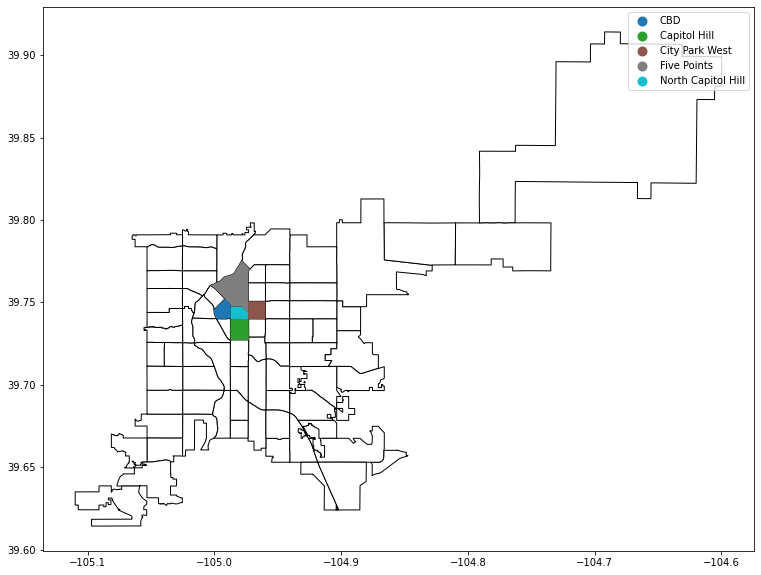

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(15,10), facecolor="white")
base = equity_data.plot(ax=ax, color = "white", edgecolor = "black")
nbrhds_of_interest.plot(column="NBRHD_NAME", ax=base, legend=True)

Displaying the indices and names of the best streets for development in each neighborhood.

North Capitol Hill:

In [103]:
best_nch_streets

,FNODE_,NCH_EVENTS,TNODE_,STREETID,MASTERID,EDITDATE,L_F_ADD,L_T_ADD,R_F_ADD,R_T_ADD,...,MORBIDITY_SCORE_right,MORTALITY_SCORE_right,BUILTENV_SCORE_right,OVERALLEQUITY_SCORE_right,EQUITY_SCORE_10_right,AVG_PDI_SCORE_right,AVG_PDI_10_right,PDI_EQUITY_DIFF_right,SHAPE_Length,SHAPE_Area_right
16740,5688.0,2.812963,5679.0,299.0,25088,20180502,401.0,499.0,400.0,498.0,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
2018,5553.0,2.585185,5554.0,298.0,3999,20180502,401.0,499.0,400.0,498.0,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
2485,5454.0,2.394444,5455.0,317.0,19579,20180502,401.0,499.0,400.0,498.0,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
9838,5862.0,2.353704,5863.0,17.0,25095,20180502,201.0,299.0,200.0,298.0,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096
4000,6036.0,2.353704,5863.0,359.0,3879,20180502,1601.0,1699.0,1600.0,1698.0,...,2.5,1.0,5.0,2.7,5.744681,8.916667,9.950766,4.206085,0.040371,0.000096


In [104]:
for i in range(len(best_nch_streets)):
  print("Street", i+1)
  print(best_nch_streets.FULLNAME.iloc[i], "from", best_nch_streets.FROMNAME.iloc[i], "to", best_nch_streets.TONAME.iloc[i])

Street 1
E 18TH AVE from N LOGAN ST/TRAFFIC SIGNAL to N PENNSYLVANIA ST
Street 2
E 19TH AVE from N LOGAN ST/TRAFFIC SIGNAL to N PENNSYLVANIA ST
Street 3
E 20TH AVE from N LOGAN ST/TRAFFIC SIGNAL to 22ND ST/N PENNSYLVANIA ST
Street 4
E 17TH AVE from N SHERMAN ST/TRAFFIC SIGNAL to N GRANT ST/TRAFFIC SIGNAL
Street 5
N GRANT ST from E 16TH AVE/TRAFFIC SIGNAL to E 17TH AVE/TRAFFIC SIGNAL


City Park West:

In [105]:
best_cpw_streets

,FNODE_,CPW_EVENTS,TNODE_,STREETID,MASTERID,EDITDATE,L_F_ADD,L_T_ADD,R_F_ADD,R_T_ADD,...,MORBIDITY_SCORE_right,MORTALITY_SCORE_right,BUILTENV_SCORE_right,OVERALLEQUITY_SCORE_right,EQUITY_SCORE_10_right,AVG_PDI_SCORE_right,AVG_PDI_10_right,PDI_EQUITY_DIFF_right,SHAPE_Length,SHAPE_Area_right
7500,5850.0,2.877011,5674.0,453.0,3762,20020930,1701.0,1799.0,1700.0,1798.0,...,2.0,1.0,4.0,2.5,5.319149,7.714286,8.60894,3.289791,0.048647,0.000146
5405,5674.0,2.673563,5678.0,299.0,3657,20180502,1301.0,1399.0,1300.0,1398.0,...,2.0,1.0,4.0,2.5,5.319149,7.714286,8.60894,3.289791,0.048647,0.000146
20409,5674.0,2.659195,20137.0,453.0,3647,20020930,1801.0,1999.0,1800.0,1998.0,...,2.0,1.0,4.0,2.5,5.319149,7.714286,8.60894,3.289791,0.048647,0.000146
6534,5856.0,2.609195,5684.0,452.0,3768,20020930,1701.0,1799.0,1700.0,1798.0,...,2.0,1.0,4.0,2.5,5.319149,7.714286,8.60894,3.289791,0.048647,0.000146
9232,5684.0,2.590230,5674.0,299.0,3660,20180502,1201.0,1299.0,1200.0,1298.0,...,2.0,1.0,4.0,2.5,5.319149,7.714286,8.60894,3.289791,0.048647,0.000146


In [106]:
for i in range(len(best_cpw_streets)):
  print("Street", i+1)
  print(best_cpw_streets.FULLNAME.iloc[i], "from", best_cpw_streets.FROMNAME.iloc[i], "to", best_cpw_streets.TONAME.iloc[i])

Street 1
N LAFAYETTE ST from E 17TH AVE to E 18TH AVE/TRAFFIC SIGNAL
Street 2
E 18TH AVE from N LAFAYETTE ST/TRAFFIC SIGNAL to N HUMBOLDT ST
Street 3
N LAFAYETTE ST from E 18TH AVE/TRAFFIC SIGNAL to E 19TH AVE/NMCHG
Street 4
N MARION ST from E 17TH AVE to E 18TH AVE
Street 5
E 18TH AVE from N MARION ST to N LAFAYETTE ST/TRAFFIC SIGNAL


Capitol Hill:

In [107]:
best_ch_streets

,FNODE_,CH_EVENTS,TNODE_,STREETID,MASTERID,EDITDATE,L_F_ADD,L_T_ADD,R_F_ADD,R_T_ADD,...,MORBIDITY_SCORE_right,MORTALITY_SCORE_right,BUILTENV_SCORE_right,OVERALLEQUITY_SCORE_right,EQUITY_SCORE_10_right,AVG_PDI_SCORE_right,AVG_PDI_10_right,PDI_EQUITY_DIFF_right,SHAPE_Length,SHAPE_Area_right
29330,7227.0,1.805224,7069.0,337.0,20767,20020930,901.0,999.0,900.0,998.0,...,4.0,1.0,4.0,3.1,6.595745,8.736842,9.750086,3.154342,0.054472,0.000184
20102,7227.0,1.772965,7224.0,678.0,4810,20180502,801.0,899.0,800.0,898.0,...,4.0,1.0,4.0,3.1,6.595745,8.736842,9.750086,3.154342,0.054472,0.000184
27124,7396.0,1.715327,7227.0,337.0,20768,20180502,801.0,899.0,800.0,898.0,...,4.0,1.0,4.0,3.1,6.595745,8.736842,9.750086,3.154342,0.054472,0.000184
20345,7232.0,1.698297,7227.0,678.0,4818,20180502,701.0,799.0,700.0,798.0,...,4.0,1.0,4.0,3.1,6.595745,8.736842,9.750086,3.154342,0.054472,0.000184
29820,7077.0,1.651056,6907.0,357.0,4691,20020930,1001.0,1099.0,1000.0,1098.0,...,4.0,1.0,4.0,3.1,6.595745,8.736842,9.750086,3.154342,0.054472,0.000184


In [108]:
for i in range(len(best_ch_streets)):
  print("Street", i+1)
  print(best_ch_streets.FULLNAME.iloc[i], "from", best_ch_streets.FROMNAME.iloc[i], "to", best_ch_streets.TONAME.iloc[i])

Street 1
N CLARKSON ST from E 9TH AVE to E 10TH AVE
Street 2
E 9TH AVE from N CLARKSON ST to N EMERSON ST
Street 3
N CLARKSON ST from E 8TH AVE/TRAFFIC SIGNAL to E 9TH AVE
Street 4
E 9TH AVE from N WASHINGTON ST to N CLARKSON ST
Street 5
N LOGAN ST from E 10TH AVE/TRAFFIC SIGNAL to E 11TH AVE/TRAFFIC SIGNAL


Five Points:

In [109]:
best_fp_streets

,FNODE_,FP_EVENTS,TNODE_,STREETID,MASTERID,EDITDATE,L_F_ADD,L_T_ADD,R_F_ADD,R_T_ADD,...,MORBIDITY_SCORE_right,MORTALITY_SCORE_right,BUILTENV_SCORE_right,OVERALLEQUITY_SCORE_right,EQUITY_SCORE_10_right,AVG_PDI_SCORE_right,AVG_PDI_10_right,PDI_EQUITY_DIFF_right,SHAPE_Length,SHAPE_Area_right
18268,4637.0,1.513470,4497.0,484.0,24970,20020930,2801.0,2899.0,2800.0,2898.0,...,3.5,1.0,3.5,2.4,5.106383,6.525,7.281729,2.175345,0.102129,0.000479
13915,4650.0,1.447077,4527.0,483.0,24954,20020930,2701.0,2799.0,2700.0,2798.0,...,3.5,1.0,3.5,2.4,5.106383,6.525,7.281729,2.175345,0.102129,0.000479
28997,4637.0,1.430754,4527.0,490.0,16768,20180502,700.0,798.0,701.0,799.0,...,3.5,1.0,3.5,2.4,5.106383,6.525,7.281729,2.175345,0.102129,0.000479
17351,5175.0,1.409667,5072.0,484.0,24965,20040607,2201.0,2299.0,2200.0,2298.0,...,3.5,1.0,3.5,2.4,5.106383,6.525,7.281729,2.175345,0.102129,0.000479
18109,4708.0,1.368575,4637.0,484.0,24971,20020930,2701.0,2799.0,2700.0,2798.0,...,3.5,1.0,3.5,2.4,5.106383,6.525,7.281729,2.175345,0.102129,0.000479


In [110]:
for i in range(len(best_fp_streets)):
  print("Street", i+1)
  print(best_fp_streets.FULLNAME.iloc[i], "from", best_fp_streets.FROMNAME.iloc[i], "to", best_fp_streets.TONAME.iloc[i])

Street 1
CALIFORNIA ST from 28TH ST to 29TH ST
Street 2
STOUT ST from 27TH ST to 28TH ST/TRAFFIC SIGNAL
Street 3
28TH ST from CALIFORNIA ST to STOUT ST/TRAFFIC SIGNAL
Street 4
CALIFORNIA ST from 22ND ST to PARK AVE W/TRAFFIC SIGNAL
Street 5
CALIFORNIA ST from 27TH ST to 28TH ST


Central Business District:

In [111]:
best_cbd_streets

,FNODE_,CBD_EVENTS,TNODE_,STREETID,MASTERID,EDITDATE,L_F_ADD,L_T_ADD,R_F_ADD,R_T_ADD,...,MORBIDITY_SCORE_right,MORTALITY_SCORE_right,BUILTENV_SCORE_right,OVERALLEQUITY_SCORE_right,EQUITY_SCORE_10_right,AVG_PDI_SCORE_right,AVG_PDI_10_right,PDI_EQUITY_DIFF_right,SHAPE_Length,SHAPE_Area_right
9822,5618.0,2.569920,5515.0,483.0,24948,20020930,1601.0,1699.0,1600.0,1698.0,...,4.0,5.0,5.0,3.7,7.872341,8.960784,10.0,2.127659,0.042534,0.000117
6184,5645.0,2.540744,5618.0,529.0,3621,20180502,700.0,798.0,701.0,799.0,...,4.0,5.0,5.0,3.7,7.872341,8.960784,10.0,2.127659,0.042534,0.000117
9450,5525.0,2.491650,5477.0,482.0,3569,20020930,1601.0,1699.0,1600.0,1698.0,...,4.0,5.0,5.0,3.7,7.872341,8.960784,10.0,2.127659,0.042534,0.000117
12683,5618.0,2.448592,5525.0,529.0,3612,20180502,800.0,898.0,801.0,899.0,...,4.0,5.0,5.0,3.7,7.872341,8.960784,10.0,2.127659,0.042534,0.000117
1852,5690.0,2.448189,5618.0,483.0,24949,20020930,1501.0,1599.0,1500.0,1598.0,...,4.0,5.0,5.0,3.7,7.872341,8.960784,10.0,2.127659,0.042534,0.000117


In [112]:
for i in range(len(best_cbd_streets)):
  print("Street", i+1)
  print(best_cbd_streets.FULLNAME.iloc[i], "from", best_cbd_streets.FROMNAME.iloc[i], "to", best_cbd_streets.TONAME.iloc[i])

Street 1
STOUT ST from 16TH ST/TRAFFIC SIGNAL to 17TH ST/TRAFFIC SIGNAL
Street 2
16TH ST from CALIFORNIA ST/TRAFFIC SIGNAL to STOUT ST/TRAFFIC SIGNAL
Street 3
CHAMPA ST from 16TH ST/TRAFFIC SIGNAL to 17TH ST/TRAFFIC SIGNAL
Street 4
16TH ST from STOUT ST/TRAFFIC SIGNAL to CHAMPA ST/TRAFFIC SIGNAL
Street 5
STOUT ST from 15TH ST/TRAFFIC SIGNAL to 16TH ST/TRAFFIC SIGNAL


Displaying all crashes and key destinations within the best neighborhoods, as well as the best streets within each neighborhood.

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:645: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  "Only specify one of 'column' or 'color'. Using 'color'.", UserWarning


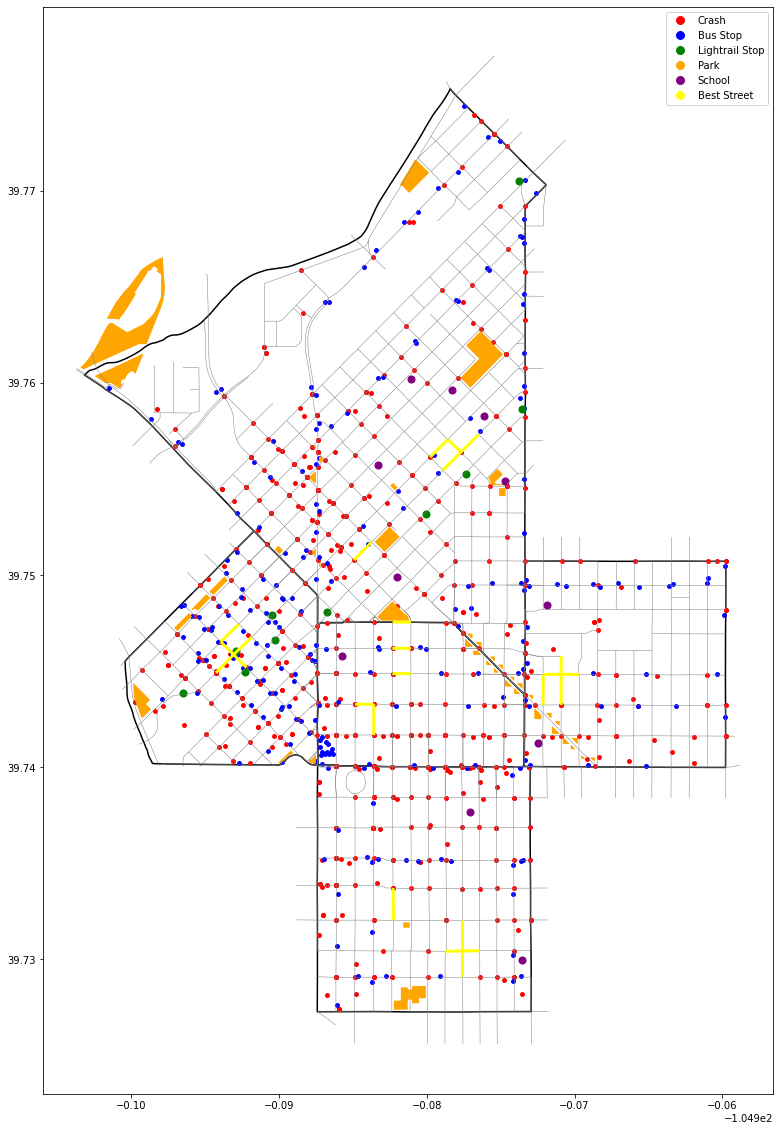

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(20,20), facecolor="white")

legend = [line.Line2D([0],[0],marker='o',color='w',label='Crash', markerfacecolor='red', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='Bus Stop', markerfacecolor='blue', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='Lightrail Stop', markerfacecolor='green', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='Park', markerfacecolor='orange', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='School', markerfacecolor='purple', markersize=10),
          line.Line2D([0],[0],marker='o',color='w',label='Best Street', markerfacecolor='yellow', markersize=10)]
ax.legend(handles=legend)

base = nbrhds_of_interest.plot(column="NBRHD_NAME", ax=ax, color="white", edgecolor="black", linewidth=1.5)
street_data.plot(ax = base, color = "grey", linewidth = 0.5)
crash_data.plot(ax = base, marker = "o", color = "red", markersize = 15)
bus_data.plot(ax = base, marker = "o", color = "blue", markersize = 15)
lightrail_data.plot(ax = base, marker = "o", color = "green", markersize = 50)
park_data.plot(ax = base, color = "orange")
school_data.plot(ax = base, color = "purple", markersize = 50)
best_nch_streets.plot(ax = base, color = "yellow", linewidth = 3)
best_cpw_streets.plot(ax = base, color = "yellow", linewidth = 3)
best_ch_streets.plot(ax = base, color = "yellow", linewidth = 3)
best_fp_streets.plot(ax = base, color = "yellow", linewidth = 3)
best_cbd_streets.plot(ax = base, color = "yellow", linewidth = 3)